# Ted Talks (Dataset with Transcripts)

From csv ted_talks_en.csv

URL:  https://www.kaggle.com/datasets/miguelcorraljr/ted-ultimate-dataset/data

Columns = 'talk_id', 'title', 'speaker_1', 'all_speakers', 'occupations', 'about_speakers', 'views', 'recorded_date', 'published_date', 'event', 'native_lang', 'available_lang', 'comments', 'duration', 'topics', 'related_talks', 'url', 'description', 'transcript'.

# Next Steps:
(as of January 22nd, 2023)

- Clean up the notebook for maximum transparency of workflow
- Reassess next steps based on feedback and re-assessment of options given the scope of the project.

In [102]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
import re
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
import string

In [103]:
# we have two csv files, one with the transcripts and one with the likes data.
# we will import them both here and merge them into one dataframe
transcript_df = pd.read_csv("TED Dataset #1 (n-4003) with Transcripts.csv")
likes_df = pd.read_csv("TED Dataset #2 (n=5701).csv")

In [104]:
# options to display all columns and rows
pd.options.display.max_rows = 40
pd.options.display.max_columns = 30
pd.options.display.max_colwidth = 50

In [105]:
# viewing the first 3 rows of the transcript dataframe
transcript_df.head(3)

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript
0,1,Averting the climate crisis,Al Gore,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,3523392,2006-02-25,2006-06-27,TED2006,en,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,977,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",https://www.ted.com/talks/al_gore_averting_the...,With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre..."
1,92,The best stats you've ever seen,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",14501685,2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,1190,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac..."
2,7,Simplicity sells,David Pogue,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,1920832,2006-02-24,2006-06-27,TED2006,en,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,1286,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",https://www.ted.com/talks/david_pogue_simplici...,New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun..."


In [106]:
# viewing the first 3 rows of the likes dataframe
likes_df.head(3)

,talk_id,title,speaker,recorded_date,published_date,event,duration,views,likes
0,1,Averting the climate crisis,Al Gore,2006-02-25,2006-06-27,TED2006,957,3681537,110000
1,7,Simplicity sells,David Pogue,2006-02-24,2006-06-27,TED2006,1266,2012797,60000
2,53,Greening the ghetto,Majora Carter,2006-02-26,2006-06-27,TED2006,1096,3006315,90000


In [107]:
# The talk_id's appear to match between the two datasets.
likes_df.loc[likes_df['talk_id'] == 92]

,talk_id,title,speaker,recorded_date,published_date,event,duration,views,likes
3,92,The best stats you've ever seen,Hans Rosling,2006-02-22,2006-06-27,TED2006,1176,15432904,462000


In [108]:
# lets check to make sure that the talk_id's are unique in the likes dataframe, 
# and check how many talk_id's in our smaller "likes_df" match those in our larger "transcript_df".  This whill show us, assuming all other information is there, how many rows we will have in our merged dataframe.
# extracting the unique talk_id's from both dataframes
unique_likes = set(likes_df['talk_id'].unique())
unique_transcripts = set(transcript_df['talk_id'].unique())
matching_talk_ids = unique_likes & unique_transcripts

# checking to see if the talk_id's are unique in the likes dataframe
if unique_likes == unique_transcripts:
    print("The talk_id's are unique in both dataframes")
    print("There are a total of:", len(matching_talk_ids), "matching unique talk_id's in the likes dataframe.  This is how many rows we will have in our merged dataframe.")
else:
    print("The talk_id's are not unique in both dataframes")
    print("There are a total of:", len(matching_talk_ids), "matching unique talk_id's in the likes dataframe.  This is how many rows we will have in our merged dataframe.")

    # finding out which 'talk_id's are different between the two dataframes
    missing_in_likes = unique_transcripts - unique_likes
    missing_in_transcripts = unique_likes - unique_transcripts

    print("There are a total of: ", len(missing_in_likes), "Missing in likes_df:", missing_in_likes)
    print("There are a total of: ", len(missing_in_transcripts), "Missing in transcripts_df:", missing_in_transcripts)

The talk_id's are not unique in both dataframes
There are a total of: 3996 matching unique talk_id's in the likes dataframe.  This is how many rows we will have in our merged dataframe.
There are a total of:  9 Missing in likes_df: {323, 45412, 2405, 2127, 3632, 2577, 2453, 2102, 347}
There are a total of:  1705 Missing in transcripts_df: {40965, 98324, 24, 8225, 57377, 57378, 81960, 81961, 81962, 81963, 90154, 90162, 81988, 98381, 98383, 81999, 82000, 82001, 82002, 82003, 82004, 65622, 82005, 82006, 73824, 73825, 82027, 57461, 41093, 82056, 82057, 138, 82058, 169, 90282, 49324, 82092, 82094, 82095, 82093, 90287, 90288, 73908, 186, 90330, 73953, 73954, 8424, 8425, 8426, 8427, 8428, 8429, 49391, 49392, 49394, 49395, 49399, 98559, 82179, 265, 74002, 74003, 74006, 98590, 98591, 65825, 290, 90404, 90405, 49450, 82218, 24874, 24876, 65856, 74051, 65876, 65877, 65878, 65879, 90453, 65881, 98662, 82289, 41330, 82290, 65915, 82299, 82300, 82301, 82302, 16778, 16779, 8590, 82318, 8592, 98706, 9

Since there are 3996 matching talk ID's this is how many talks we have to analyze (prior to data cleaning and pre-processing).

### Merging the two dataframes

#### Renaming matching columns:

In [110]:
# lets check to see which columns match between the two dataframes

# Extracting unique column names from both dataframes
unique_likes_columns = set(likes_df.columns)
unique_transcripts_columns = set(transcript_df.columns)
matching_columns = unique_likes_columns & unique_transcripts_columns

# Checking to see if the column names are identical in both dataframes
if unique_likes_columns == unique_transcripts_columns:
    print("The columns are identical in both dataframes.")
else:
    print("The column names are not identical in both dataframes.")
    print("There are a total of:", len(matching_columns), "matching unique columns. These are: ", matching_columns)

The column names are not identical in both dataframes.
There are a total of: 7 matching unique columns. These are:  {'duration', 'event', 'recorded_date', 'views', 'title', 'published_date', 'talk_id'}


As there are 7 columns that are matching, I will add a "_from_likes_df" to the likes dataframe to distinguish between them after merging.

In [111]:
# I will add a suffix of "_new" to this more updated dataset, so that I know which columns are from which dataset after merging them.
# Select the columns you want to rename
columns_to_modify = ['duration', 'event', 'recorded_date', 'views', 'title', 'published_date']

# Create a dictionary where the keys are the old column names and the values are the new column names
renamed_columns = {col: col + '_from_likes_df' for col in columns_to_modify}

# Rename the columns in the DataFrame
likes_df.rename(columns=renamed_columns, inplace=True)
likes_df.head(3)

,talk_id,title_from_likes_df,speaker,recorded_date_from_likes_df,published_date_from_likes_df,event_from_likes_df,duration_from_likes_df,views_from_likes_df,likes
0,1,Averting the climate crisis,Al Gore,2006-02-25,2006-06-27,TED2006,957,3681537,110000
1,7,Simplicity sells,David Pogue,2006-02-24,2006-06-27,TED2006,1266,2012797,60000
2,53,Greening the ghetto,Majora Carter,2006-02-26,2006-06-27,TED2006,1096,3006315,90000


### Ready to merge the dataframes

In [112]:
# I will now merge the two dataframes together, using the talk_id as the key.
merged_df = transcript_df.merge(likes_df, on='talk_id')
merged_df.head(3)

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript,title_from_likes_df,speaker,recorded_date_from_likes_df,published_date_from_likes_df,event_from_likes_df,duration_from_likes_df,views_from_likes_df,likes
0,1,Averting the climate crisis,Al Gore,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,3523392,2006-02-25,2006-06-27,TED2006,en,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,977,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",https://www.ted.com/talks/al_gore_averting_the...,With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre...",Averting the climate crisis,Al Gore,2006-02-25,2006-06-27,TED2006,957,3681537,110000
1,92,The best stats you've ever seen,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",14501685,2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,1190,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac...",The best stats you've ever seen,Hans Rosling,2006-02-22,2006-06-27,TED2006,1176,15432904,462000
2,7,Simplicity sells,David Pogue,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,1920832,2006-02-24,2006-06-27,TED2006,en,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,1286,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",https://www.ted.com/talks/david_pogue_simplici...,New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun...",Simplicity sells,David Pogue,2006-02-24,2006-06-27,TED2006,1266,2012797,60000


In [10]:
merged_df.shape

(3996, 27)

There are 3996 rows and 27 columns in the dataframe.

### Cleaning Up The Merged Dataframe Columns

In [11]:
merged_df[["duration_x", "duration_y"]]

,duration_x,duration_y
0,977,957
1,1190,1176
2,1286,1266
3,1116,1096
4,1164,1151
...,...,...
3991,690,680
3992,346,346
3993,774,764
3994,257,257


In [16]:
# After the merge of these dataframes, 
merged_df.isnull().sum()

talk_id               0
title_x               0
speaker_1             0
all_speakers          4
occupations         522
about_speakers      503
views                 0
recorded_date_x       1
published_date_x      0
event_x               0
native_lang           0
available_lang        0
comments            654
duration_x            0
topics                0
related_talks         0
url                   0
description           0
transcript            0
title_y               0
speaker               0
recorded_date_y       0
published_date_y      0
event_y               0
duration_y            0
views_new             0
likes_new             0
word_count            0
words_per_minute      0
dtype: int64

## Where we'll go from here:

- Remove duplicate columns
- Clean column names
- Determine what to do with nulls
- Create a "percent_likes" feature
- Create a binanry "main_stage" feature (from "event", which ones are mainstage TED talks vs which ones are 'Tedx'-like talks)

- Exclude the transcript from a dataframe for initial EDA
- One-hot encode non-numerical data 

- Run a linear regression with "percent_likes" as the target variable
- Determine the top 100 positive coefficients to see what most correlates with "percent_likes"
- Determine the top 100 negative coefficients to see what most correlates with "percent_likes"
- Scale the columns, and the repeat the linear regression to see what effect this had

## Where we'll go from here:

- Remove duplicate columns

In [17]:
# here we'll remove duplicate columns
merged_cleaved_df = merged_df.drop(["speaker_1", "title_x", "views", "recorded_date_x", "published_date_x", "event_x", "duration_x"], axis=1)
merged_cleaved_df

,talk_id,all_speakers,occupations,about_speakers,native_lang,available_lang,comments,topics,related_talks,url,description,transcript,title_y,speaker,recorded_date_y,published_date_y,event_y,duration_y,views_new,likes_new,word_count,words_per_minute
0,1,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,en,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",https://www.ted.com/talks/al_gore_averting_the...,With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre...",Averting the climate crisis,Al Gore,2006-02-25,2006-06-27,TED2006,957,3681537,110000,2153,2.203685
1,92,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",en,"['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac...",The best stats you've ever seen,Hans Rosling,2006-02-22,2006-06-27,TED2006,1176,15432904,462000,3174,2.667227
2,7,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,en,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",https://www.ted.com/talks/david_pogue_simplici...,New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun...",Simplicity sells,David Pogue,2006-02-24,2006-06-27,TED2006,1266,2012797,60000,3371,2.621306
3,53,{0: 'Majora Carter'},{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,en,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,"['MacArthur grant', 'activism', 'business', 'c...",{1041: '3 stories of local eco-entrepreneurshi...,https://www.ted.com/talks/majora_carter_greeni...,"In an emotionally charged talk, MacArthur-winn...",If you're here today — and I'm very happy that...,Greening the ghetto,Majora Carter,2006-02-26,2006-06-27,TED2006,1096,3006315,90000,3071,2.751792
4,66,{0: 'Sir Ken Robinson'},"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...",en,"['af', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs...",4931.0,"['children', 'creativity', 'culture', 'dance',...","{865: 'Bring on the learning revolution!', 173...",https://www.ted.com/talks/sir_ken_robinson_do_...,Sir Ken Robinson makes an entertaining and pro...,Good morning. How are you? (Audience) Good. It...,Do schools kill creativity?,Sir Ken Robinson,2006-02-25,2006-06-27,TED2006,1151,73935964,2200000,3170,2.723368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3991,62678,{0: 'Nancy Lublin'},{0: ['health activist']},"{0: 'Nancy Lublin, cofounder and CEO of Crisis...",en,['en'],6.0,"['activism', 'data', 'technology', 'mental hea...",{2362: 'How data from a crisis text line is sa...,https://www.ted.com/talks/nancy_lublin_crisis_...,What if we could help people in crisis anytime...,"""I'm 14, and I want to go home."" ""My name is B...","Crisis support for the world, one text away",Nancy Lublin,2020-04-22,2020-04-27,TED2020,680,1014188,30000,1735,2.514493
3992,62782,{0: 'Stefan C Dombrowski'},NaN,NaN,en,"['en', 'es', 'my', 'pt-br']",NaN,"['TED-Ed', 'education', 'history', 'animation'...",{35386: 'How does the Rorschach inkblot test w...,https://www.ted.com/talks/stefan_c_dombrowski_...,"In 1905, psychologists Alfred Binet and Théodo...","In 1905, psychologists Alfred Binet and Théodo...",The dark history of IQ tests,Stefan C. Dombrowski,2020-04-27,2020-04-27,TED-Ed,346,2111794,63000,743,2.147399
3993,62263,{0: 'Dick M. Carpenter II'},{0: ['law researcher']}

## Where we'll go from here:
- Clean column names

In [18]:
# Here we're removing the '_y' from any column names that have it
merged_cleaved_df.columns = [col.rstrip('_y') if col.endswith('_y') else col for col in merged_cleaved_df.columns]
merged_cleaved_df.columns = [col.rstrip('_new') if col.endswith('_new') else col for col in merged_cleaved_df.columns]
merged_cleaved_df

,talk_id,all_speakers,occupations,about_speakers,native_lang,available_lang,comments,topics,related_talks,url,description,transcript,title,speaker,recorded_date,published_date,event,duration,views,likes,word_count,words_per_minute
0,1,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,en,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",https://www.ted.com/talks/al_gore_averting_the...,With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre...",Averting the climate crisis,Al Gore,2006-02-25,2006-06-27,TED2006,957,3681537,110000,2153,2.203685
1,92,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",en,"['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac...",The best stats you've ever seen,Hans Rosling,2006-02-22,2006-06-27,TED2006,1176,15432904,462000,3174,2.667227
2,7,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,en,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",https://www.ted.com/talks/david_pogue_simplici...,New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun...",Simplicity sells,David Pogue,2006-02-24,2006-06-27,TED2006,1266,2012797,60000,3371,2.621306
3,53,{0: 'Majora Carter'},{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,en,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,"['MacArthur grant', 'activism', 'business', 'c...",{1041: '3 stories of local eco-entrepreneurshi...,https://www.ted.com/talks/majora_carter_greeni...,"In an emotionally charged talk, MacArthur-winn...",If you're here today — and I'm very happy that...,Greening the ghetto,Majora Carter,2006-02-26,2006-06-27,TED2006,1096,3006315,90000,3071,2.751792
4,66,{0: 'Sir Ken Robinson'},"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...",en,"['af', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs...",4931.0,"['children', 'creativity', 'culture', 'dance',...","{865: 'Bring on the learning revolution!', 173...",https://www.ted.com/talks/sir_ken_robinson_do_...,Sir Ken Robinson makes an entertaining and pro...,Good morning. How are you? (Audience) Good. It...,Do schools kill creativity?,Sir Ken Robinson,2006-02-25,2006-06-27,TED2006,1151,73935964,2200000,3170,2.723368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3991,62678,{0: 'Nancy Lublin'},{0: ['health activist']},"{0: 'Nancy Lublin, cofounder and CEO of Crisis...",en,['en'],6.0,"['activism', 'data', 'technology', 'mental hea...",{2362: 'How data from a crisis text line is sa...,https://www.ted.com/talks/nancy_lublin_crisis_...,What if we could help people in crisis anytime...,"""I'm 14, and I want to go home."" ""My name is B...","Crisis support for the world, one text away",Nancy Lublin,2020-04-22,2020-04-27,TED2020,680,1014188,30000,1735,2.514493
3992,62782,{0: 'Stefan C Dombrowski'},NaN,NaN,en,"['en', 'es', 'my', 'pt-br']",NaN,"['TED-Ed', 'education', 'history', 'animation'...",{35386: 'How does the Rorschach inkblot test w...,https://www.ted.com/talks/stefan_c_dombrowski_...,"In 1905, psychologists Alfred Binet and Théodo...","In 1905, psychologists Alfred Binet and Théodo...",The dark history of IQ tests,Stefan C. Dombrowski,2020-04-27,2020-04-27,TED-Ed,346,2111794,63000,743,2.147399
3993,62263,{0: 'Dick M. Carpenter II'},{0: ['law researcher']},{0: 'Dick M. Carp

## Where we'll go from here:

- Determine what to do with nulls

In [19]:
merged_cleaved_df.isnull().sum()

talk_id               0
all_speakers          4
occupations         522
about_speakers      503
native_lang           0
available_lang        0
comments            654
topics                0
related_talks         0
url                   0
description           0
transcript            0
title                 0
speaker               0
recorded_date         0
published_date        0
event                 0
duration              0
views                 0
likes                 0
word_count            0
words_per_minute      0
dtype: int64

In [20]:
merged_cleaved_df.shape

(3996, 22)

In [21]:
# Lets see what happens to the 3996 rows when we drop the null values
merged_cleaved_df.dropna(inplace=True)

In [22]:
merged_cleaved_df.shape

(3331, 22)

For the moment, while removing nulls will result in ((3996-3331) / 3996 = 0.1664) 16.4% of the data being thrown out, there is no simple way to scrape this data from the TED website, so we will continue without this data. 

## Where we'll go from here:
- Create a "percent_likes" feature

In [23]:
# here we'll create a "percent_likes" column, which is the percentage of likes out of the total views
merged_cleaved_df['percent_likes'] = merged_cleaved_df['likes'] / merged_cleaved_df['views']
merged_cleaved_df

,talk_id,all_speakers,occupations,about_speakers,native_lang,available_lang,comments,topics,related_talks,url,description,transcript,title,speaker,recorded_date,published_date,event,duration,views,likes,word_count,words_per_minute,percent_likes
0,1,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,en,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",https://www.ted.com/talks/al_gore_averting_the...,With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre...",Averting the climate crisis,Al Gore,2006-02-25,2006-06-27,TED2006,957,3681537,110000,2153,2.203685,0.029879
1,92,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",en,"['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac...",The best stats you've ever seen,Hans Rosling,2006-02-22,2006-06-27,TED2006,1176,15432904,462000,3174,2.667227,0.029936
2,7,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,en,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",https://www.ted.com/talks/david_pogue_simplici...,New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun...",Simplicity sells,David Pogue,2006-02-24,2006-06-27,TED2006,1266,2012797,60000,3371,2.621306,0.029809
3,53,{0: 'Majora Carter'},{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,en,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,"['MacArthur grant', 'activism', 'business', 'c...",{1041: '3 stories of local eco-entrepreneurshi...,https://www.ted.com/talks/majora_carter_greeni...,"In an emotionally charged talk, MacArthur-winn...",If you're here today — and I'm very happy that...,Greening the ghetto,Majora Carter,2006-02-26,2006-06-27,TED2006,1096,3006315,90000,3071,2.751792,0.029937
4,66,{0: 'Sir Ken Robinson'},"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...",en,"['af', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs...",4931.0,"['children', 'creativity', 'culture', 'dance',...","{865: 'Bring on the learning revolution!', 173...",https://www.ted.com/talks/sir_ken_robinson_do_...,Sir Ken Robinson makes an entertaining and pro...,Good morning. How are you? (Audience) Good. It...,Do schools kill creativity?,Sir Ken Robinson,2006-02-25,2006-06-27,TED2006,1151,73935964,2200000,3170,2.723368,0.029755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3985,62628,{0: 'Tom Rivett-Carnac'},{0: ['political strategist']},{0: 'A political strategist focused on creatin...,en,"['en', 'pt-br']",31.0,"['climate change', 'choice', 'leadership', 'so...",{2480: 'The inside story of the Paris climate ...,https://www.ted.com/talks/tom_rivett_carnac_ho...,"When it comes to big life problems, we often s...",I never thought that I would be giving my TED ...,How to shift your mindset and choose your future,Tom Rivett-Carnac,2020-04-22,2020-04-22,TED2020,944,2924068,87000,2753,2.885744,0.029753
3986,62627,{0: 'Oliver Jeffers'},"{0: ['artist', 'storyteller']}","{0: 'With a style that crackles with wry wit, ...",en,"['ar', 'en', 'fa', 'fr', 'tr']",12.0,"['Planets', 'art', 'poetry', 'life', 'love', '...",{44696: 'You are not alone in your loneliness'...,https://www.ted.com/talks/oliver_jeffers_an_od...,If you had to explain to a newborn what it mea...,[Oliver Jeffers] [An ode to living on Earth] H...,An ode to living on E

## Where we'll go from here:

- Create a binanry "main_stage" feature (from "event", which ones are mainstage TED talks vs which ones are 'Tedx'-like talks)

In [24]:
# Here we'll create a 'ted_mainstage' column, which is a boolean column that is True if the talk was performed at a mainstream "TED" event, and False if it was not.
# This is a regex pattern that matches the TED events that are not TEDx or TED Global
mainstage = '^\s*TED\d{4}\s*$'

# Create a binary column based on the condition
merged_cleaved_df['ted_mainstage'] = merged_cleaved_df['event'].str.match(mainstage).astype(int)
merged_cleaved_df['ted_mainstage'].value_counts()


ted_mainstage
0    2152
1    1179
Name: count, dtype: int64

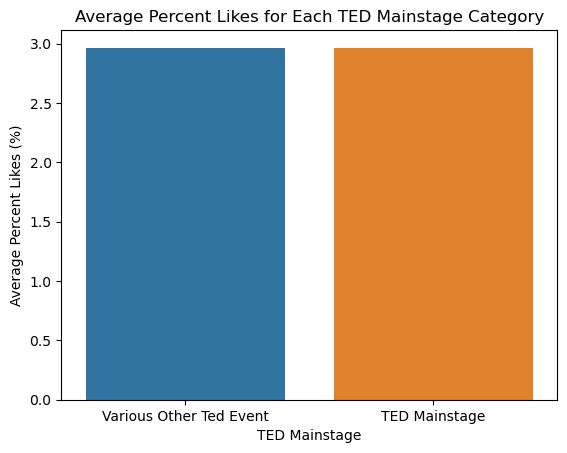

In [25]:
# Calculating the average 'percent_likes' for each 'ted_mainstage' value, and multiplying by 100 to convert to percentage format
average_likes = merged_cleaved_df.groupby('ted_mainstage')['percent_likes'].mean() * 100

# Plotting
sns.barplot(x=average_likes.index, y=average_likes.values)
plt.xlabel('TED Mainstage')
plt.ylabel('Average Percent Likes (%)') # Updated label to indicate percentage
plt.title('Average Percent Likes for Each TED Mainstage Category')
plt.xticks([0,1], labels=['Various Other Ted Event', 'TED Mainstage'])
plt.show()


## Where we'll go from here:

- Exclude the transcript from a dataframe for initial EDA

In [26]:
merged_cleaved_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3331 entries, 0 to 3993
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   talk_id           3331 non-null   int64  
 1   all_speakers      3331 non-null   object 
 2   occupations       3331 non-null   object 
 3   about_speakers    3331 non-null   object 
 4   native_lang       3331 non-null   object 
 5   available_lang    3331 non-null   object 
 6   comments          3331 non-null   float64
 7   topics            3331 non-null   object 
 8   related_talks     3331 non-null   object 
 9   url               3331 non-null   object 
 10  description       3331 non-null   object 
 11  transcript        3331 non-null   object 
 12  title             3331 non-null   object 
 13  speaker           3331 non-null   object 
 14  recorded_date     3331 non-null   object 
 15  published_date    3331 non-null   object 
 16  event             3331 non-null   object 
 17  

We're going to, one by one, determine what to do with each of the "object" columns.  

#### Addressing 'object' columns - changing them into numerical values, or dropping them altogether.

We'll start with "all_speakers" (for this section of the notebook, the column we are addressing in the section below will be made a headline, as is "all_speakers" below)

#### - all_speakers      3331 non-null   object 
- occupations       3331 non-null   object 
- about_speakers   3331 non-null   object 
- native_lang       3331 non-null   object 
- available_lang    3331 non-null   object 
- comments          3331 non-null   float64
- topics            3331 non-null   object 
- related_talks     3331 non-null   object 
- url               3331 non-null   object 
- description       3331 non-null   object 
- transcript        3331 non-null   object 
- title             3331 non-null   object 
- speaker           3331 non-null   object 
- recorded_date     3331 non-null   object 
- published_date    3331 non-null   object 
- event             3331 non-null   object 

In [27]:
merged_cleaved_df["all_speakers"].value_counts()

all_speakers
{0: 'Greg Gage'}               9
{0: 'Juan Enriquez'}           9
{0: 'Hans Rosling'}            9
{0: 'Marco Tempest'}           7
{0: ' Rives'}                  6
                              ..
{0: 'Ryan Merkley'}            1
{0: 'Pankaj Ghemawat'}         1
{0: 'David Pizarro'}           1
{0: 'Lemn Sissay'}             1
{0: 'Dick M. Carpenter II'}    1
Name: count, Length: 2852, dtype: int64

In [28]:
# Let's find out how many talks have multiple speakers
# Assuming all_speakers is a list of dictionaries
all_speakers = merged_cleaved_df["all_speakers"]

# Initialize a counter
count = 0

# Iterate through each dictionary in the list
for speaker_dict in all_speakers:
    # Check if the key "1" exists in the dictionary
    if "1" in speaker_dict:
        count += 1

# Output the result
print(f"Number of dictionaries with a key '1': {count}")

Number of dictionaries with a key '1': 103


There are 103 talks with multiple speakers in them.  
As we are primarily concerned with the talks primary speaker, I will remove this column.

As much of the data in 'all_speakers' is redundant as it repeats the value of the main speaker, we will drop this column.

In [29]:
# Dropping the "all_speakers" column, as it is not useful for our analysis
merged_cleaved_df.drop(["all_speakers"], axis=1, inplace=True)

#### Addressing 'object' columns - changing them into numerical values, or dropping them altogether.

- all_speakers      3331 non-null   object 
#### - occupations       3331 non-null   object 
- about_speakers   3331 non-null   object 
- native_lang       3331 non-null   object 
- available_lang    3331 non-null   object 
- comments          3331 non-null   float64
- topics            3331 non-null   object 
- related_talks     3331 non-null   object 
- url               3331 non-null   object 
- description       3331 non-null   object 
- transcript        3331 non-null   object 
- title             3331 non-null   object 
- speaker           3331 non-null   object 
- recorded_date     3331 non-null   object 
- published_date    3331 non-null   object 
- event             3331 non-null   object 

In [30]:
merged_cleaved_df["occupations"].value_counts()

occupations
{0: ['writer']}                                   52
{0: ['journalist']}                               43
{0: ['entrepreneur']}                             42
{0: ['artist']}                                   40
{0: ['designer']}                                 37
                                                  ..
{0: ['bow designer']}                              1
{0: ['explorer and filmmaker']}                    1
{0: ['human-computer interaction researcher']}     1
{0: ['composer', 'inventor'], 1: ['musician']}     1
{0: ['law researcher']}                            1
Name: count, Length: 1982, dtype: int64

In [31]:
# Here we're going to split the "occupations" column into a list of occupations

def transform_occupation(occupation_str):
    # Extracting the part after "{0: " and before the first occurrence of "],"
    match = re.search(r"\{0: \[([^\]]*)\]", occupation_str)
    if match:
        occupations = match.group(1)
        # Remove quotes and split by comma to get individual occupations
        occupations = occupations.replace("'", "").split(", ")
        # Replace spaces within occupations with underscores
        occupations = [occupation.replace(" ", "_") for occupation in occupations]
        # Join the occupations back with a space
        return " ".join(occupations)
    else:
        # Return an empty string or some default value if the pattern is not found
        return ""

# Apply the function to the 'occupations' column
merged_cleaved_df['transformed_occupations'] = merged_cleaved_df['occupations'].apply(transform_occupation)
merged_cleaved_df['transformed_occupations'].value_counts()


transformed_occupations
writer                             54
journalist                         44
entrepreneur                       43
artist                             41
designer                           37
                                   ..
former_prime_minister_of_greece     1
graphic_artist director             1
dolphin_researcher                  1
undercover_journalist               1
law_researcher                      1
Name: count, Length: 1924, dtype: int64

In [32]:
# Load your actual DataFrame here
# merged_cleaved_df = pd.read_csv('your_file.csv')

# Convert 'transformed_occupations' into dummy variables
occupation_dummies = pd.get_dummies(merged_cleaved_df['transformed_occupations'], drop_first=True)

# Define X and y
X = occupation_dummies
y = merged_cleaved_df['percent_likes']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Adding a constant to the model for the training data
X_train = sm.add_constant(X_train)

# Linear Regression on Training Data
model = sm.OLS(y_train, X_train)
result = model.fit()

# Optionally: Evaluate model performance on test data
X_test = sm.add_constant(X_test)
predictions = result.predict(X_test)


# Getting the coefficients from the trained model
coefficients = result.params

# Dropping the constant for the purpose of this analysis
coefficients = coefficients.drop('const', errors='ignore')

# Sorting the coefficients
sorted_coefficients = coefficients.sort_values()

# Selecting the top 10 positive and negative coefficients
top_10_positive = sorted_coefficients.tail(10)
top_10_negative = sorted_coefficients.head(10)

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot for top 10 positive coefficients
top_10_positive.plot(kind='barh', ax=axes[0], color='green')
axes[0].set_title('Top 10 Positive Coefficients')
axes[0].set_xlabel('Coefficient Value')
axes[0].set_ylabel('Occupations')

# Plot for top


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [33]:
merged_cleaved_df['percent_likes']

0       0.029879
1       0.029936
2       0.029809
3       0.029937
4       0.029755
          ...   
3985    0.029753
3986    0.029726
3990    0.029619
3991    0.029580
3993    0.029630
Name: percent_likes, Length: 3331, dtype: float64

In [34]:
occupation_dummies

,"""childrens_book_author""","""general_manager_of_microsofts_virtual_earth""","""researchers_dream_donator""","""victims_rights_attorney""","""womens-health_expert""","""womens_advocate""","""womens_health_advocate""","""womens_health_pioneer""","""womens_rights_activist""",3d_printer,3d_printing_entrepreneur,9/11_mothers,a_capella_ensemble,academic,academic author,...,writer youth_worker freedom_fighter,writer_and_editor,writer_and_philosopher,writer_and_poet,writer_and_radio_host,writer_and_radio_producer,wrongologist,x-ray_visionary,yo-yo_champion,yogurt_maker humanitarian,youth_inventor,youtube_educator,zoologist,zoologist author explorer,zoologist venom_researcher
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3985,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3986,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3990,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3991,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


#### Addressing 'object' columns - changing them into numerical values, or dropping them altogether.

- all_speakers      3331 non-null   object 
- occupations       3331 non-null   object 
#### - about_speakers  3331 non-null   object 
- native_lang       3331 non-null   object 
- available_lang    3331 non-null   object 
- comments          3331 non-null   float64
- topics            3331 non-null   object 
- related_talks     3331 non-null   object 
- url               3331 non-null   object 
- description       3331 non-null   object 
- transcript        3331 non-null   object 
- title             3331 non-null   object 
- speaker           3331 non-null   object 
- recorded_date     3331 non-null   object 
- published_date    3331 non-null   object 
- event             3331 non-null   object 

In [35]:
merged_cleaved_df['about_speakers']

0       {0: 'Nobel Laureate Al Gore focused the world’...
1       {0: 'In Hans Rosling’s hands, data sings. Glob...
2       {0: 'David Pogue is the personal technology co...
3       {0: 'Majora Carter redefined the field of envi...
4       {0: "Creativity expert Sir Ken Robinson challe...
                              ...                        
3985    {0: 'A political strategist focused on creatin...
3986    {0: 'With a style that crackles with wry wit, ...
3990    {0: "TED Prize winner Larry Brilliant has spen...
3991    {0: 'Nancy Lublin, cofounder and CEO of Crisis...
3993    {0: 'Dick M. Carpenter II studies cutting edge...
Name: about_speakers, Length: 3331, dtype: object

In [36]:
# Here we're going to remove the data that deals with the SECOND speaker's bio, as it is not useful for our analysis
# Define a function to extract text from the first key ("0") if the entry is a dictionary
def extract_first_key_text(entry):
    if isinstance(entry, dict):  # Check if the entry is a dictionary
        return entry.get("0", "")  # Return value for key "0" or an empty string if key "0" doesn't exist
    else:
        return entry  # Return the entry as it is if it's not a dictionary

# Apply this function to the about_speakers column
merged_cleaved_df['about_speakers'] = merged_cleaved_df['about_speakers'].apply(extract_first_key_text)
merged_cleaved_df['about_speakers']

0       {0: 'Nobel Laureate Al Gore focused the world’...
1       {0: 'In Hans Rosling’s hands, data sings. Glob...
2       {0: 'David Pogue is the personal technology co...
3       {0: 'Majora Carter redefined the field of envi...
4       {0: "Creativity expert Sir Ken Robinson challe...
                              ...                        
3985    {0: 'A political strategist focused on creatin...
3986    {0: 'With a style that crackles with wry wit, ...
3990    {0: "TED Prize winner Larry Brilliant has spen...
3991    {0: 'Nancy Lublin, cofounder and CEO of Crisis...
3993    {0: 'Dick M. Carpenter II studies cutting edge...
Name: about_speakers, Length: 3331, dtype: object

In [37]:
# Let's find out how many talks have multiple speakers
# Assuming all_speakers is a list of dictionaries
all_speakers = merged_cleaved_df["about_speakers"]

# Initialize a counter
count = 0

# Iterate through each dictionary in the list
for speaker_dict in all_speakers:
    # Check if the key "1" exists in the dictionary
    if "1" in speaker_dict:
        count += 1

# Output the result
print(f"Number of dictionaries with a key '1': {count}")

Number of dictionaries with a key '1': 267


We MAY re-approach this problem later, as it is uncertain if teh presence of these dictionary keys matters at the moment. 

#### Addressing 'object' columns - changing them into numerical values, or dropping them altogether.

- all_speakers      3331 non-null   object **DROPPED**
- occupations       3331 non-null   object **ready for dummy variables**
- about_speakers    3331 non-null   object **ready for vectorization**
#### - native_lang       3331 non-null   object 
- available_lang    3331 non-null   object 
- comments          3331 non-null   float64
- topics            3331 non-null   object 
- related_talks     3331 non-null   object 
- url               3331 non-null   object 
- description       3331 non-null   object 
- transcript        3331 non-null   object 
- title             3331 non-null   object 
- speaker           3331 non-null   object 
- recorded_date     3331 non-null   object 
- published_date    3331 non-null   object 
- event             3331 non-null   object 

In [38]:
merged_cleaved_df["native_lang"].value_counts()

native_lang
en       3299
es         15
fr          7
hi          2
de          1
pt          1
ko          1
zh-cn       1
ar          1
pt-br       1
ja          1
it          1
Name: count, dtype: int64

As the vast majority of this column represents English ("en") as being the native language, we will drop this column.

In [39]:
merged_cleaved_df = merged_cleaved_df.drop("native_lang", axis=1)
merged_cleaved_df

,talk_id,occupations,about_speakers,available_lang,comments,topics,related_talks,url,description,transcript,title,speaker,recorded_date,published_date,event,duration,views,likes,word_count,words_per_minute,percent_likes,ted_mainstage,transformed_occupations
0,1,{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",https://www.ted.com/talks/al_gore_averting_the...,With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre...",Averting the climate crisis,Al Gore,2006-02-25,2006-06-27,TED2006,957,3681537,110000,2153,2.203685,0.029879,1,climate_advocate
1,92,{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...","['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac...",The best stats you've ever seen,Hans Rosling,2006-02-22,2006-06-27,TED2006,1176,15432904,462000,3174,2.667227,0.029936,1,global_health_expert;_data_visionary
2,7,{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",https://www.ted.com/talks/david_pogue_simplici...,New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun...",Simplicity sells,David Pogue,2006-02-24,2006-06-27,TED2006,1266,2012797,60000,3371,2.621306,0.029809,1,technology_columnist
3,53,{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,"['MacArthur grant', 'activism', 'business', 'c...",{1041: '3 stories of local eco-entrepreneurshi...,https://www.ted.com/talks/majora_carter_greeni...,"In an emotionally charged talk, MacArthur-winn...",If you're here today — and I'm very happy that...,Greening the ghetto,Majora Carter,2006-02-26,2006-06-27,TED2006,1096,3006315,90000,3071,2.751792,0.029937,1,activist_for_environmental_justice
4,66,"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...","['af', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs...",4931.0,"['children', 'creativity', 'culture', 'dance',...","{865: 'Bring on the learning revolution!', 173...",https://www.ted.com/talks/sir_ken_robinson_do_...,Sir Ken Robinson makes an entertaining and pro...,Good morning. How are you? (Audience) Good. It...,Do schools kill creativity?,Sir Ken Robinson,2006-02-25,2006-06-27,TED2006,1151,73935964,2200000,3170,2.723368,0.029755,1,author educator
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3985,62628,{0: ['political strategist']},{0: 'A political strategist focused on creatin...,"['en', 'pt-br']",31.0,"['climate change', 'choice', 'leadership', 'so...",{2480: 'The inside story of the Paris climate ...,https://www.ted.com/talks/tom_rivett_carnac_ho...,"When it comes to big life problems, we often s...",I never thought that I would be giving my TED ...,How to shift your mindset and choose your future,Tom Rivett-Carnac,2020-04-22,2020-04-22,TED2020,944,2924068,87000,2753,2.885744,0.029753,1,political_strategist
3986,62627,"{0: ['artist', 'storyteller']}","{0: 'With a style that crackles with wry wit, ...","['ar', 'en', 'fa', 'fr', 'tr']",12.0,"['Planets', 'art', 'poetry', 'life', 'love', '...",{44696: 'You are not alone in your loneliness'...,https://www.ted.com/talks/oliver_jeffers_an_od...,If you had to explain to a newborn what it mea...,[Oliver Jeffers] [An ode to living on Earth] H...,An ode to living

#### Addressing 'object' columns - changing them into numerical values, or dropping them altogether.

- all_speakers      3331 non-null   object **DROPPED**
- occupations       3331 non-null   object **ready for dummy variables**
- about_speakers    3331 non-null   object **ready for vectorization**
- native_lang       3331 non-null   object **DROPPED**
#### - available_lang    3331 non-null   object **Create dummies?**
- comments          3331 non-null   float64
- topics            3331 non-null   object 
- related_talks     3331 non-null   object 
- url               3331 non-null   object 
- description       3331 non-null   object 
- transcript        3331 non-null   object 
- title             3331 non-null   object 
- speaker           3331 non-null   object 
- recorded_date     3331 non-null   object 
- published_date    3331 non-null   object 
- event             3331 non-null   object 

In [40]:
merged_cleaved_df["available_lang"].value_counts()

available_lang
['en']                                                                                                                                                                                                          14
['ar', 'bg', 'de', 'el', 'en', 'es', 'fr', 'he', 'it', 'ja', 'ko', 'nl', 'pl', 'pt-br', 'ro', 'ru', 'tr', 'vi', 'zh-cn', 'zh-tw']                                                                                6
['ar', 'bg', 'de', 'en', 'es', 'fr', 'he', 'it', 'ja', 'ko', 'nl', 'pl', 'pt-br', 'ro', 'ru', 'tr', 'vi', 'zh-cn', 'zh-tw']                                                                                      4
['ar', 'bg', 'de', 'en', 'es', 'fr', 'he', 'it', 'ja', 'ko', 'nl', 'pl', 'pt', 'pt-br', 'ro', 'ru', 'sr', 'tr', 'vi', 'zh-cn', 'zh-tw']                                                                          4
['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa', 'fr', 'he', 'hr', 'hu', 'id', 'it', 'ja', 'ko', 'nl', 'pl', 'pt', 'pt-br', 'ro', 'ru', 'sk',

As I am uncertain what to do here, I will investigate further how to best handle the above data.  

My current opinion is to create dummy variables for them.

#### Addressing 'object' columns - changing them into numerical values, or dropping them altogether.

- all_speakers      3331 non-null   object **DROPPED**
- occupations       3331 non-null   object **ready for dummy variables**
- about_speakers    3331 non-null   object **ready for vectorization**
- native_lang       3331 non-null   object **DROPPED**
- available_lang    3331 non-null   object **Create dummies?**
#### - comments          3331 non-null   float64
- topics            3331 non-null   object 
- related_talks     3331 non-null   object 
- url               3331 non-null   object 
- description       3331 non-null   object 
- transcript        3331 non-null   object 
- title             3331 non-null   object 
- speaker           3331 non-null   object 
- recorded_date     3331 non-null   object 
- published_date    3331 non-null   object 
- event             3331 non-null   object 

The comments are ready for processing as they are already numerically represented. 

#### Addressing 'object' columns - changing them into numerical values, or dropping them altogether.

- all_speakers      3331 non-null   object **DROPPED**
- occupations       3331 non-null   object **ready for dummy variables**
- about_speakers    3331 non-null   object **ready for vectorization**
- native_lang       3331 non-null   object **DROPPED**
- available_lang    3331 non-null   object **Create dummies?**
- comments          3331 non-null   float64 **Ready for analysis**
#### - topics            3331 non-null   object 
- related_talks     3331 non-null   object 
- url               3331 non-null   object 
- description       3331 non-null   object 
- transcript        3331 non-null   object 
- title             3331 non-null   object 
- speaker           3331 non-null   object 
- recorded_date     3331 non-null   object 
- published_date    3331 non-null   object 
- event             3331 non-null   object 

In [41]:
merged_cleaved_df["topics"].value_counts()

topics
['culture', 'love', 'relationships', 'sex']                                                                                                                                                                                  2
['cities', 'culture', 'design', 'transportation']                                                                                                                                                                            2
['charter for compassion', 'compassion', 'global issues', 'religion']                                                                                                                                                        2
['design', 'entertainment', 'live music', 'music', 'technology']                                                                                                                                                             2
['architecture', 'cities', 'design', 'infrastructure']                                               

#### Addressing 'object' columns - changing them into numerical values, or dropping them altogether.

- all_speakers      3331 non-null   object **DROPPED**
- occupations       3331 non-null   object **ready for dummy variables**
- about_speakers    3331 non-null   object **ready for vectorization**
- native_lang       3331 non-null   object **DROPPED**
- available_lang    3331 non-null   object **Create dummies?**
- comments          3331 non-null   float64 **Ready for analysis**
- topics            3331 non-null   object **Create dummies?**
#### - related_talks     3331 non-null   object 
- url               3331 non-null   object 
- description       3331 non-null   object 
- transcript        3331 non-null   object 
- title             3331 non-null   object 
- speaker           3331 non-null   object 
- recorded_date     3331 non-null   object 
- published_date    3331 non-null   object 
- event             3331 non-null   object 

In [42]:
merged_cleaved_df["related_talks"].value_counts()

related_talks
{243: 'New thinking on the climate crisis', 547: 'The business logic of sustainability', 2093: 'The state of the climate — and what we might do about it', 54715: 'How we can turn the tide on climate', 29968: 'The most important thing you can do to fight climate change: talk about it', 2339: "Climate change is happening. Here's how we adapt"}                     1
{2413: 'Capitalism will eat democracy -- unless we speak up', 1765: 'Imagine a European democracy without borders', 1949: 'My wish: To launch a new era of openness in business', 2604: "We've stopped trusting institutions and started trusting strangers", 52270: 'How online marketplaces can help local economies, not hurt them', 661: 'The post-crisis consumer'}    1
{1040: 'Why we have too few women leaders', 2384: 'The US needs paid family leave -- for the sake of its future', 2272: 'The single biggest reason why start-ups succeed', 31235: 'This is what makes employees happy at work', 33778: '8 lessons on building 

I do believe that this could be valuable information, so I will use a CountVectorizer to vectorize this text.

#### Addressing 'object' columns - changing them into numerical values, or dropping them altogether.

- all_speakers      3331 non-null   object **DROPPED**
- occupations       3331 non-null   object **ready for dummy variables**
- about_speakers    3331 non-null   object **ready for vectorization**
- native_lang       3331 non-null   object **DROPPED**
- available_lang    3331 non-null   object **Create dummies?**
- comments          3331 non-null   float64 **Ready for analysis**
- topics            3331 non-null   object **Create dummies?**
- related_talks     3331 non-null   object **CountVectorize?**
#### - url               3331 non-null   object **Dropped**
- description       3331 non-null   object 
- transcript        3331 non-null   object 
- title             3331 non-null   object 
- speaker           3331 non-null   object 
- recorded_date     3331 non-null   object 
- published_date    3331 non-null   object 
- event             3331 non-null   object 

We will drop the URL column.

In [43]:
# dropping the URL column
merged_cleaved_df.drop(["url"], axis=1, inplace=True)

#### Addressing 'object' columns - changing them into numerical values, or dropping them altogether.

- all_speakers      3331 non-null   object **DROPPED**
- occupations       3331 non-null   object **ready for dummy variables**
- about_speakers    3331 non-null   object **ready for vectorization**
- native_lang       3331 non-null   object **DROPPED**
- available_lang    3331 non-null   object **Create dummies?**
- comments          3331 non-null   float64 **Ready for analysis**
- topics            3331 non-null   object **Create dummies?**
- related_talks     3331 non-null   object **CountVectorize?**
- url               3331 non-null   object **Dropped**
#### - description       3331 non-null   object 
- transcript        3331 non-null   object 
- title             3331 non-null   object 
- speaker           3331 non-null   object 
- recorded_date     3331 non-null   object 
- published_date    3331 non-null   object 
- event             3331 non-null   object 

In [44]:
merged_cleaved_df["description"].value_counts()

description
With the same humor and humanity he exuded in "An Inconvenient Truth," Al Gore spells out 15 ways that individuals can address climate change immediately, from buying a hybrid to inventing a new, hotter brand name for global warming.                                                                                                                                                                                                                                                                                                                                                                                                                                                               1
Margrethe Vestager wants to keep European markets competitive -- which is why, on behalf of the EU, she's fined Google $2.8 billion for breaching antitrust rules, asked Apple for $15.3 billion in back taxes and investigated a range of companies, from Gazprom to Fiat, for anti-competitive practices. In an 

This column is ready to be CountVectorized.

#### Addressing 'object' columns - changing them into numerical values, or dropping them altogether.

- all_speakers      3331 non-null   object **DROPPED**
- occupations       3331 non-null   object **ready for dummy variables**
- about_speakers    3331 non-null   object **ready for vectorization**
- native_lang       3331 non-null   object **DROPPED**
- available_lang    3331 non-null   object **Create dummies?**
- comments          3331 non-null   float64 **Ready for analysis**
- topics            3331 non-null   object **Create dummies?**
- related_talks     3331 non-null   object **CountVectorize?**
- url               3331 non-null   object **Dropped**
- description       3331 non-null   object **CountVectorize?**
#### - transcript        3331 non-null   object 
- title             3331 non-null   object 
- speaker           3331 non-null   object 
- recorded_date     3331 non-null   object 
- published_date    3331 non-null   object 
- event             3331 non-null   object 

In [45]:
merged_cleaved_df["transcript"].value_counts()

transcript
Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful. I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night. And I say that sincerely, partly because (Mock sob) I need that. (Laughter) Put yourselves in my position. (Laughter) I flew on Air Force Two for eight years. (Laughter) Now I have to take off my shoes or boots to get on an airplane! (Laughter) (Applause) I'll tell you one quick story to illustrate what that's been like for me. (Laughter) It's a true story — every bit of this is true. Soon after Tipper and I left the — (Mock sob) White House — (Laughter) we were driving from our home in Nashville to a little farm we have 50 miles east of Nashville. Driving ourselves. (Laughter) I know it sounds like a little thing to you, but — (Laughter) I looked in the rear-view mirror and all of a sudden it just hit me.

This column is ready to be CountVectorized.

#### Addressing 'object' columns - changing them into numerical values, or dropping them altogether.

- all_speakers      3331 non-null   object **DROPPED**
- occupations       3331 non-null   object **ready for dummy variables**
- about_speakers    3331 non-null   object **ready for vectorization**
- native_lang       3331 non-null   object **DROPPED**
- available_lang    3331 non-null   object **Create dummies?**
- comments          3331 non-null   float64 **Ready for analysis**
- topics            3331 non-null   object **Create dummies?**
- related_talks     3331 non-null   object **CountVectorize?**
- url               3331 non-null   object **Dropped**
- description       3331 non-null   object **CountVectorize?**
- transcript        3331 non-null   object **CountVectorize?**
#### - title             3331 non-null   object 
- speaker           3331 non-null   object 
- recorded_date     3331 non-null   object 
- published_date    3331 non-null   object 
- event             3331 non-null   object 

In [46]:
merged_cleaved_df["title"].value_counts()

title
Averting the climate crisis                                    1
The new age of corporate monopolies                            1
Why you should know how much your coworkers get paid           1
Why open a school? To close a prison                           1
The era of personal DNA testing is here                        1
                                                              ..
A TED speaker's worst nightmare                                1
Design to challenge reality                                    1
Why you will fail to have a great career                       1
The cockroach beatbox                                          1
The injustice of "policing for profit" -- and how to end it    1
Name: count, Length: 3331, dtype: int64

I am considering Dummying this column.  But what about dummying and then, separately, countvectorizing?  

#### Addressing 'object' columns - changing them into numerical values, or dropping them altogether.

- all_speakers      3331 non-null   object **DROPPED**
- occupations       3331 non-null   object **ready for dummy variables**
- about_speakers    3331 non-null   object **ready for vectorization**
- native_lang       3331 non-null   object **DROPPED**
- available_lang    3331 non-null   object **Create dummies?**
- comments          3331 non-null   float64 **Ready for analysis**
- topics            3331 non-null   object **Create dummies?**
- related_talks     3331 non-null   object **CountVectorize?**
- url               3331 non-null   object **Dropped**
- description       3331 non-null   object **CountVectorize?**
- transcript        3331 non-null   object **CountVectorize?**
- title             3331 non-null   object **Dummy OR CountVectorize**?
#### - speaker           3331 non-null   object 
- recorded_date     3331 non-null   object 
- published_date    3331 non-null   object 
- event             3331 non-null   object 

In [47]:
merged_cleaved_df["speaker"].value_counts()

speaker
Hans Rosling                9
Greg Gage                   9
Juan Enriquez               9
Marco Tempest               7
Bill Gates                  6
                           ..
Maurizio Seracini           1
Eddie Obeng                 1
John Wilbanks               1
Beau Lotto + Amy O'Toole    1
Dick M. Carpenter II        1
Name: count, Length: 2844, dtype: int64

I am considering dummying this column, or should I CountVectorize?

#### Addressing 'object' columns - changing them into numerical values, or dropping them altogether.

- all_speakers      3331 non-null   object **DROPPED**
- occupations       3331 non-null   object **ready for dummy variables**
- about_speakers    3331 non-null   object **ready for vectorization**
- native_lang       3331 non-null   object **DROPPED**
- available_lang    3331 non-null   object **Create dummies?**
- comments          3331 non-null   float64 **Ready for analysis**
- topics            3331 non-null   object **Create dummies?**
- related_talks     3331 non-null   object **CountVectorize?**
- url               3331 non-null   object **Dropped**
- description       3331 non-null   object **CountVectorize?**
- transcript        3331 non-null   object **CountVectorize?**
- title             3331 non-null   object **Dummy OR CountVectorize**?
- speaker           3331 non-null   object **Dummy OR CountVectorize**?
#### - recorded_date     3331 non-null   object 
#### - published_date    3331 non-null   object 
- event             3331 non-null   object 

## Feature Engineering

#### We will create the following features:
- word_count (from the "transcript" column) [x]
- words_per_minute (total_words_count / duration) [x]
- total_laugh_count ("Laughter" is included in the transcripts, and we will sum these occurances )
- laugh_per_minute (total_laugh_count / durtaion)
- total_question_count (summing the instances of "?" in the transcript)
- questions_per_minute (total_question_count / duration)

#### Word count columns

In [ ]:
# Lets create another column that counts the number of words in the transcript.
# A function that counts words in a string
def count_words(text):
    # Splitting the text into words and count them
    return len(text.split())

# Apply this function to each row in the 'transcript' column and create a new column
merged_df['word_count'] = merged_df['transcript'].apply(count_words)


In [ ]:
merged_df.head(2)

,talk_id,title_x,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date_x,published_date_x,event_x,native_lang,available_lang,comments,duration_x,topics,related_talks,url,description,transcript,title_y,speaker,recorded_date_y,published_date_y,event_y,duration_y,views_new,likes_new,word_count
0,1,Averting the climate crisis,Al Gore,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,3523392,2006-02-25,2006-06-27,TED2006,en,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,977,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",https://www.ted.com/talks/al_gore_averting_the...,With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre...",Averting the climate crisis,Al Gore,2006-02-25,2006-06-27,TED2006,957,3681537,110000,2153
1,92,The best stats you've ever seen,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",14501685,2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,1190,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac...",The best stats you've ever seen,Hans Rosling,2006-02-22,2006-06-27,TED2006,1176,15432904,462000,3174
2,7,Simplicity sells,David Pogue,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,1920832,2006-02-24,2006-06-27,TED2006,en,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,1286,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",https://www.ted.com/talks/david_pogue_simplici...,New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun...",Simplicity sells,David Pogue,2006-02-24,2006-06-27,TED2006,1266,2012797,60000,3371
3,53,Greening the ghetto,Majora Carter,{0: 'Majora Carter'},{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,2664069,2006-02-26,2006-06-27,TED2006,en,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,1116,"['MacArthur grant', 'activism', 'business', 'c...",{1041: '3 stories of local eco-entrepreneurshi...,https://www.ted.com/talks/majora_carter_greeni...,"In an emotionally charged talk, MacArthur-winn...",If you're here today — and I'm very happy that...,Greening the ghetto,Majora Carter,2006-02-26,2006-06-27,TED2006,1096,3006315,90000,3071
4,66,Do schools kill creativity?,Sir Ken Robinson,{0: 'Sir Ken Robinson'},"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...",65051954,2006-02-25,2006-06-27,TED2006,en,"['af', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs...",4931.0,1164,"['children', 'creativity', 'culture', 'dance',...","{865: 'Bring on the learning revolution!', 173...",https://www.ted.com/talks/sir_ken_robinson_do_...,Sir Ken Robinson makes an entertaining and pro...,Good morning. How are you? (Audience) Good. It...,Do schools kill creativity?,Sir Ken Robinson,2006-02-25,2006-06-27,TED2006,1151,73935964,2200000,3170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3991,62678,"Crisis support for the world, one text away",Nancy Lublin,{0: 'Nancy Lublin'},{0: ['health activist']},"{0: 'Nancy Lublin, cofounder and CEO of Crisis...",502934,2020-04-22,2020-04-27,TED2020: The Prequel,en,['en'],6.0,690,"['activism', 'data', 'technology', 'mental hea...",{2362: 'How data from a crisis text line is sa...,https://www.ted.com/talks/nancy_lublin_crisis_...,What if we could help people in crisis anytime...,"""I'm 14, and I want to go home."" ""My name is B...","Crisis support for the world, one text away",Nancy Lublin,2020-04-22,2020-0

In [ ]:
# words count per minute
merged_df['words_per_minute'] = merged_df['word_count'] / merged_df['duration_x']

In [ ]:
merged_df.head(2)

,talk_id,title_x,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date_x,published_date_x,event_x,native_lang,available_lang,comments,duration_x,topics,related_talks,url,description,transcript,title_y,speaker,recorded_date_y,published_date_y,event_y,duration_y,views_new,likes_new,word_count,words_per_minute
0,1,Averting the climate crisis,Al Gore,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,3523392,2006-02-25,2006-06-27,TED2006,en,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,977,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",https://www.ted.com/talks/al_gore_averting_the...,With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre...",Averting the climate crisis,Al Gore,2006-02-25,2006-06-27,TED2006,957,3681537,110000,2153,2.203685
1,92,The best stats you've ever seen,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",14501685,2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,1190,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac...",The best stats you've ever seen,Hans Rosling,2006-02-22,2006-06-27,TED2006,1176,15432904,462000,3174,2.667227
2,7,Simplicity sells,David Pogue,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,1920832,2006-02-24,2006-06-27,TED2006,en,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,1286,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",https://www.ted.com/talks/david_pogue_simplici...,New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun...",Simplicity sells,David Pogue,2006-02-24,2006-06-27,TED2006,1266,2012797,60000,3371,2.621306
3,53,Greening the ghetto,Majora Carter,{0: 'Majora Carter'},{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,2664069,2006-02-26,2006-06-27,TED2006,en,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,1116,"['MacArthur grant', 'activism', 'business', 'c...",{1041: '3 stories of local eco-entrepreneurshi...,https://www.ted.com/talks/majora_carter_greeni...,"In an emotionally charged talk, MacArthur-winn...",If you're here today — and I'm very happy that...,Greening the ghetto,Majora Carter,2006-02-26,2006-06-27,TED2006,1096,3006315,90000,3071,2.751792
4,66,Do schools kill creativity?,Sir Ken Robinson,{0: 'Sir Ken Robinson'},"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...",65051954,2006-02-25,2006-06-27,TED2006,en,"['af', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs...",4931.0,1164,"['children', 'creativity', 'culture', 'dance',...","{865: 'Bring on the learning revolution!', 173...",https://www.ted.com/talks/sir_ken_robinson_do_...,Sir Ken Robinson makes an entertaining and pro...,Good morning. How are you? (Audience) Good. It...,Do schools kill creativity?,Sir Ken Robinson,2006-02-25,2006-06-27,TED2006,1151,73935964,2200000,3170,2.723368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3991,62678,"Crisis support for the world, one text away",Nancy Lublin,{0: 'Nancy Lublin'},{0: ['health activist']},"{0: 'Nancy Lublin, cofounder and CEO of Crisis...",502934,2020-04-22,2020-04-27,TED2020: The Prequel,en,['en'],6.0,690,"['activism', 'data', 'technology', 'mental hea...",{2362: 'How data from a crisis text line is sa...,https://www.ted.com/talks/nancy_lublin_crisis_...,What if we could help people in crisis anytime...,"""I'm 14, and I want to go home."" ""My name is B...","Crisis su

#### Date features:
- Changing "published_date" and "recorded_date" to DateTime [x]
- Published month [x]
- Published year [x]
- Recorded month [x]
- Recorded year [x]

I will change these dates into DateTime datatypes.

In [48]:
merged_cleaved_df["published_date"] = pd.to_datetime(merged_cleaved_df["published_date"])
merged_cleaved_df["recorded_date"] = pd.to_datetime(merged_cleaved_df["recorded_date"])

In [49]:
merged_cleaved_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3331 entries, 0 to 3993
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   talk_id                  3331 non-null   int64         
 1   occupations              3331 non-null   object        
 2   about_speakers           3331 non-null   object        
 3   available_lang           3331 non-null   object        
 4   comments                 3331 non-null   float64       
 5   topics                   3331 non-null   object        
 6   related_talks            3331 non-null   object        
 7   description              3331 non-null   object        
 8   transcript               3331 non-null   object        
 9   title                    3331 non-null   object        
 10  speaker                  3331 non-null   object        
 11  recorded_date            3331 non-null   datetime64[ns]
 12  published_date           3331 non-null 

#### Addressing 'object' columns - changing them into numerical values, or dropping them altogether.

- all_speakers      3331 non-null   object **DROPPED**
- occupations       3331 non-null   object **ready for dummy variables**
- about_speakers    3331 non-null   object **ready for vectorization**
- native_lang       3331 non-null   object **DROPPED**
- available_lang    3331 non-null   object **Create dummies?**
- comments          3331 non-null   float64 **Ready for analysis**
- topics            3331 non-null   object **Create dummies?**
- related_talks     3331 non-null   object **CountVectorize?**
- url               3331 non-null   object **Dropped**
- description       3331 non-null   object **CountVectorize?**
- transcript        3331 non-null   object **CountVectorize?**
- title             3331 non-null   object **Dummy OR CountVectorize**?
- speaker           3331 non-null   object **Dummy OR CountVectorize**?
- recorded_date     3331 non-null   object **Changed to DateTime**
- published_date    3331 non-null   object **Changed to DateTime**
- event             3331 non-null   object 

#### Additional Columns Created:
- published_year
- published_month
- recorded_year
- recorded_month

#### Creating Additional Columns:

- published_year
- published_month
- recorded_year
- recorded_month

In [50]:
# I am creating additional columns for the year and month of the published and recorded dates
merged_cleaved_df["published_year"] = merged_cleaved_df["published_date"].dt.year
merged_cleaved_df["published_month"] = merged_cleaved_df["published_date"].dt.month
merged_cleaved_df["recorded_year"] = merged_cleaved_df["recorded_date"].dt.year
merged_cleaved_df["recorded_month"] = merged_cleaved_df["recorded_date"].dt.month

#### Creating Additional Columns:

- num_question_marks
- questions_per_minute
- num_laughs
- laughs_per_minute

Here we're going to create numerical columns called "questions_per_minute" and "laughs_per_minute".

In [51]:
# Define a function that counts question marks in a given string
def count_question_marks(text):
    return text.count('?')

# Apply this function to each row of the 'transcript' column and store the result in a new column
merged_cleaved_df['num_question_marks'] = merged_cleaved_df['transcript'].apply(count_question_marks)
merged_cleaved_df['questions_per_minute'] = merged_cleaved_df['num_question_marks'] / merged_cleaved_df['duration']
merged_cleaved_df.head(3)

,talk_id,occupations,about_speakers,available_lang,comments,topics,related_talks,description,transcript,title,speaker,recorded_date,published_date,event,duration,views,likes,word_count,words_per_minute,percent_likes,ted_mainstage,transformed_occupations,published_year,published_month,recorded_year,recorded_month,num_question_marks,questions_per_minute
0,1,{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre...",Averting the climate crisis,Al Gore,2006-02-25,2006-06-27,TED2006,957,3681537,110000,2153,2.203685,0.029879,1,climate_advocate,2006,6,2006,2,8,0.008359
1,92,{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...","['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac...",The best stats you've ever seen,Hans Rosling,2006-02-22,2006-06-27,TED2006,1176,15432904,462000,3174,2.667227,0.029936,1,global_health_expert;_data_visionary,2006,6,2006,2,22,0.018707
2,7,{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun...",Simplicity sells,David Pogue,2006-02-24,2006-06-27,TED2006,1266,2012797,60000,3371,2.621306,0.029809,1,technology_columnist,2006,6,2006,2,35,0.027646


In [52]:
# Create a function that counts the number of "(Laughter)" in a string.
def count_laughter(text):
    # Splitting the text into words and count them
    return text.count("(Laughter)")

# Apply this function to each row of the 'transcript' column and store the result in a new column
merged_cleaved_df['num_laughs'] = merged_cleaved_df['transcript'].apply(count_laughter)
merged_cleaved_df['laughs_per_minute'] = merged_cleaved_df['num_laughs'] / merged_cleaved_df['duration']
merged_cleaved_df.head(3)

,talk_id,occupations,about_speakers,available_lang,comments,topics,related_talks,description,transcript,title,speaker,recorded_date,published_date,event,duration,views,likes,word_count,words_per_minute,percent_likes,ted_mainstage,transformed_occupations,published_year,published_month,recorded_year,recorded_month,num_question_marks,questions_per_minute,num_laughs,laughs_per_minute
0,1,{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre...",Averting the climate crisis,Al Gore,2006-02-25,2006-06-27,TED2006,957,3681537,110000,2153,2.203685,0.029879,1,climate_advocate,2006,6,2006,2,8,0.008359,22,0.022989
1,92,{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...","['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac...",The best stats you've ever seen,Hans Rosling,2006-02-22,2006-06-27,TED2006,1176,15432904,462000,3174,2.667227,0.029936,1,global_health_expert;_data_visionary,2006,6,2006,2,22,0.018707,9,0.007653
2,7,{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun...",Simplicity sells,David Pogue,2006-02-24,2006-06-27,TED2006,1266,2012797,60000,3371,2.621306,0.029809,1,technology_columnist,2006,6,2006,2,35,0.027646,38,0.030016


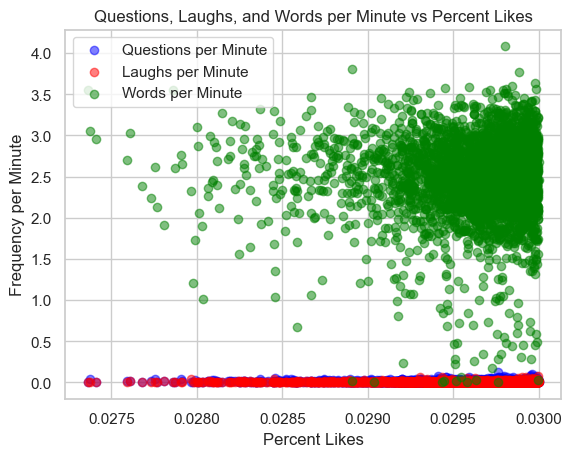

In [53]:
# Set the style of seaborn for better visualization
sns.set(style="whitegrid")

# Create a scatter plot for 'questions_per_minute'
plt.scatter(merged_cleaved_df['percent_likes'], merged_cleaved_df['questions_per_minute'], color='blue', alpha=0.5, label='Questions per Minute')

# Create a scatter plot for 'laughs_per_minute' on the same axes
plt.scatter(merged_cleaved_df['percent_likes'], merged_cleaved_df['laughs_per_minute'], color='red', alpha=0.5, label='Laughs per Minute')

# Create a scatter plot for 'words_per_minute' on the same axes
plt.scatter(merged_cleaved_df['percent_likes'], merged_cleaved_df['words_per_minute'], color='green', alpha=0.5, label='Words per Minute')

# Adding title and labels
plt.title('Questions, Laughs, and Words per Minute vs Percent Likes')
plt.xlabel('Percent Likes')
plt.ylabel('Frequency per Minute')

# Adding legend to distinguish the groups
plt.legend()

# Show the plot
plt.show()

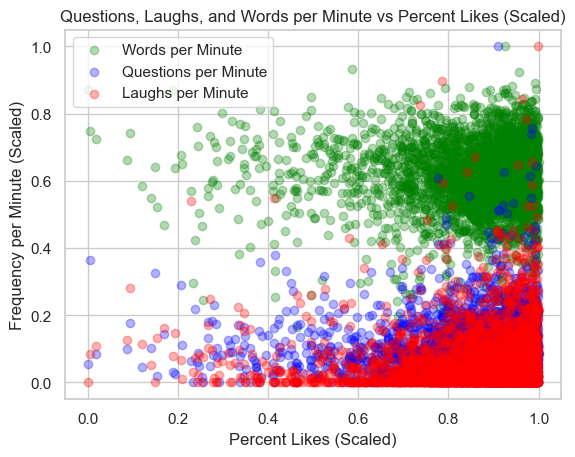

In [54]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is already defined as merged_cleaved_df

# Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# List of columns to scale
columns_to_scale = ['questions_per_minute', 'laughs_per_minute', 'words_per_minute', 'percent_likes']

# Scale the selected columns and replace in the dataframe
merged_cleaved_df[columns_to_scale] = scaler.fit_transform(merged_cleaved_df[columns_to_scale])

# Set the style of seaborn for better visualization
sns.set(style="whitegrid")

# Create scatter plots for the scaled variables
plt.scatter(merged_cleaved_df['percent_likes'], merged_cleaved_df['words_per_minute'], color='green', alpha=0.3, label='Words per Minute')
plt.scatter(merged_cleaved_df['percent_likes'], merged_cleaved_df['questions_per_minute'], color='blue', alpha=0.3, label='Questions per Minute')
plt.scatter(merged_cleaved_df['percent_likes'], merged_cleaved_df['laughs_per_minute'], color='red', alpha=0.3, label='Laughs per Minute')


# Adding title and labels
plt.title('Questions, Laughs, and Words per Minute vs Percent Likes (Scaled)')
plt.xlabel('Percent Likes (Scaled)')
plt.ylabel('Frequency per Minute (Scaled)')

# Adding legend to distinguish the groups
plt.legend()

# Show the plot
plt.show()




In [55]:
merged_cleaved_df.columns

Index(['talk_id', 'occupations', 'about_speakers', 'available_lang',
       'comments', 'topics', 'related_talks', 'description', 'transcript',
       'title', 'speaker', 'recorded_date', 'published_date', 'event',
       'duration', 'views', 'likes', 'word_count', 'words_per_minute',
       'percent_likes', 'ted_mainstage', 'transformed_occupations',
       'published_year', 'published_month', 'recorded_year', 'recorded_month',
       'num_question_marks', 'questions_per_minute', 'num_laughs',
       'laughs_per_minute'],
      dtype='object')

In [56]:
merged_cleaved_df["topics"].value_counts()

topics
['culture', 'love', 'relationships', 'sex']                                                                                                                                                                                  2
['cities', 'culture', 'design', 'transportation']                                                                                                                                                                            2
['charter for compassion', 'compassion', 'global issues', 'religion']                                                                                                                                                        2
['design', 'entertainment', 'live music', 'music', 'technology']                                                                                                                                                             2
['architecture', 'cities', 'design', 'infrastructure']                                               

In [57]:
# Which topics are most positively correlated with percent_likes?

from sklearn.preprocessing import MultiLabelBinarizer

# Assuming your DataFrame is already defined as merged_cleaved_df

# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Transform 'topics' column into a format where each topic is a separate column
topics_encoded = mlb.fit_transform(merged_cleaved_df['topics'])

# Creating a DataFrame from the transformed topics
topics_df = pd.DataFrame(topics_encoded, columns=mlb.classes_)

# Concatenating the new DataFrame with the original DataFrame
merged_cleaved_df_expanded = pd.concat([merged_cleaved_df.reset_index(drop=True), topics_df], axis=1)


In [58]:
# Adding 'percent_likes' to the topics DataFrame for correlation analysis
topics_with_likes = pd.concat([topics_df, merged_cleaved_df['percent_likes'].reset_index(drop=True)], axis=1)

# Calculating the correlation
correlation = topics_with_likes.corr()

# Displaying the correlation of each topic with 'percent_likes'
print(correlation['percent_likes'])


                 0.018698
"                0.014762
'                     NaN
,                0.018698
-                0.033140
                   ...   
x               -0.036674
y               -0.000618
z               -0.006553
ñ               -0.044341
percent_likes    1.000000
Name: percent_likes, Length: 56, dtype: float64


In [59]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

# Assuming your DataFrame is already defined as merged_cleaved_df
# Ensure that each row in 'topics' column is a list. If it's a string representation of a list, you'll need to convert it back to a list
# For example, you might need to use ast.literal_eval if your lists are stored as strings

import ast
merged_cleaved_df['topics'] = merged_cleaved_df['topics'].apply(ast.literal_eval)



In [60]:
# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Transform 'topics' column into a format where each topic is a separate column
topics_encoded = mlb.fit_transform(merged_cleaved_df['topics'])

# Creating a DataFrame from the transformed topics
topics_df = pd.DataFrame(topics_encoded, columns=mlb.classes_)

# Adding 'percent_likes' to the topics DataFrame for correlation analysis
topics_with_likes = pd.concat([topics_df, merged_cleaved_df['percent_likes'].reset_index(drop=True)], axis=1)

# Calculating the correlation
correlation = topics_with_likes.corr()['percent_likes']

# Dropping 'percent_likes' correlation with itself
correlation = correlation.drop(labels=['percent_likes'])

# Sorting the correlations to find the top 100 topics
top_20_topics = correlation.sort_values(ascending=False).head(20)
bottom_20_topics = correlation.sort_values(ascending=True).head(20)

# Displaying the top 100 topics
print(top_20_topics)
print(bottom_20_topics)

society            0.095641
personal growth    0.092737
leadership         0.089082
work               0.083429
psychology         0.071348
social change      0.070698
humanity           0.070085
motivation         0.069287
education          0.063377
goal-setting       0.061169
inequality         0.059359
success            0.058640
brain              0.058562
mind               0.058281
relationships      0.057727
communication      0.056524
United States      0.055003
teaching           0.052633
personality        0.052341
decision-making    0.051438
Name: percent_likes, dtype: float64
design             -0.103616
global issues      -0.100319
technology         -0.069891
disaster relief    -0.066308
india              -0.066106
live music         -0.063070
oceans             -0.060140
mission blue       -0.059877
music              -0.054292
natural disaster   -0.053216
marine biology     -0.052706
typography         -0.049934
war                -0.049544
Best of the Web    -0.04901

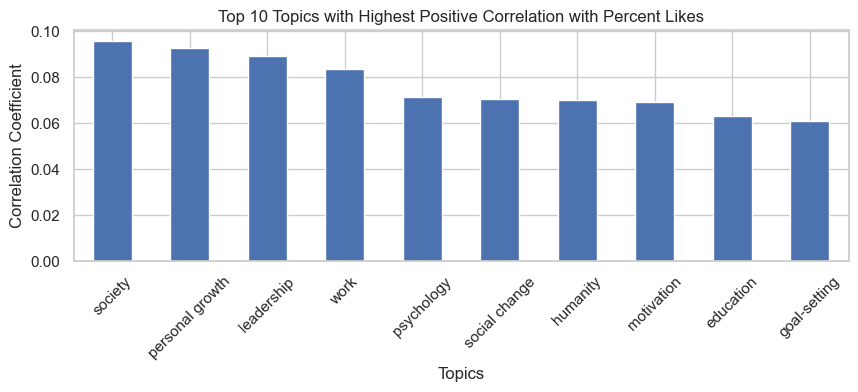

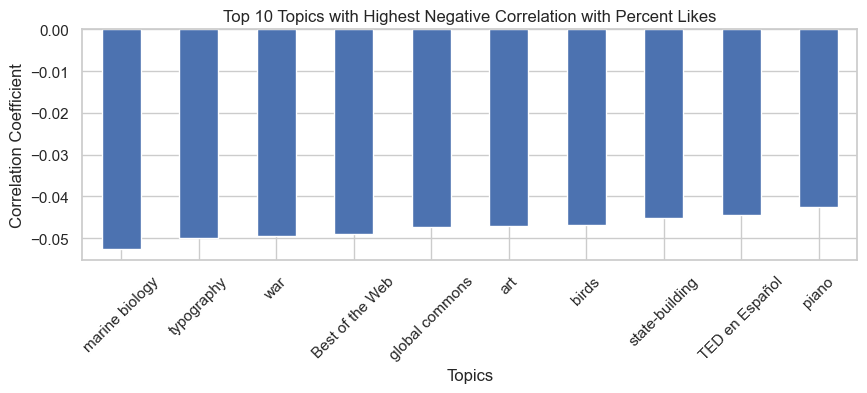

In [61]:
import matplotlib.pyplot as plt

# Top 10 topics with highest positive correlation
top_10_positive_topics = top_20_topics.head(10)

# Top 10 topics with highest negative correlation
# Remember, in bottom_100_topics, the most negative correlations are at the end, so we use tail()
top_10_negative_topics = bottom_20_topics.tail(10)

# Plotting the top 10 topics with highest positive correlation
plt.figure(figsize=(10, 3))
top_10_positive_topics.plot(kind='bar')
plt.title('Top 10 Topics with Highest Positive Correlation with Percent Likes')
plt.xlabel('Topics')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.show()

# Plotting the top 10 topics with highest negative correlation
plt.figure(figsize=(10, 3))
top_10_negative_topics.plot(kind='bar')
plt.title('Top 10 Topics with Highest Negative Correlation with Percent Like NOTE I DID THIS WRONG!!!')
plt.xlabel('Topics')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.show()


In [570]:
correlation = merged_cleaved_df[['questions_per_minute', 'laughs_per_minute', 'words_per_minute', 'percent_likes', 'ted_mainstage', 'published_year', 'published_month', 'recorded_year', 'recorded_month']].corr()
print(correlation['percent_likes'])


questions_per_minute    0.045850
laughs_per_minute       0.081054
words_per_minute       -0.018726
percent_likes           1.000000
ted_mainstage           0.043747
published_year          0.165824
published_month        -0.011722
recorded_year           0.182274
recorded_month         -0.009939
Name: percent_likes, dtype: float64


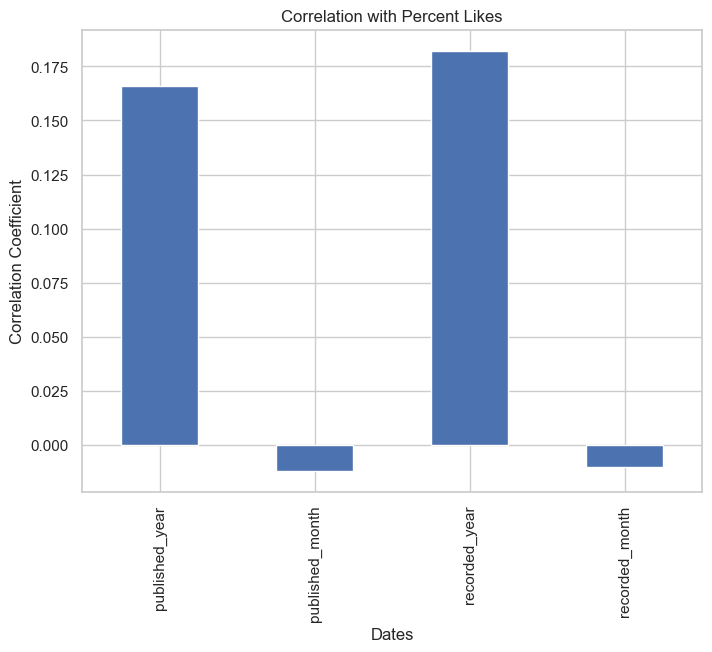

In [580]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your actual DataFrame here
# merged_cleaved_df = pd.read_csv('your_file.csv')

# Calculate the correlation matrix
correlation = merged_cleaved_df[['published_year', 'published_month', 'recorded_year', 'recorded_month', 'percent_likes']].corr()

# Extracting the correlation of specified columns with 'percent_likes'
correlation_with_percent_likes = correlation['percent_likes'].drop('percent_likes', errors='ignore')

# Plotting a bar chart
plt.figure(figsize=(8, 6))
correlation_with_percent_likes.plot(kind='bar')
plt.title('Correlation with Percent Likes')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Dates')
plt.show()


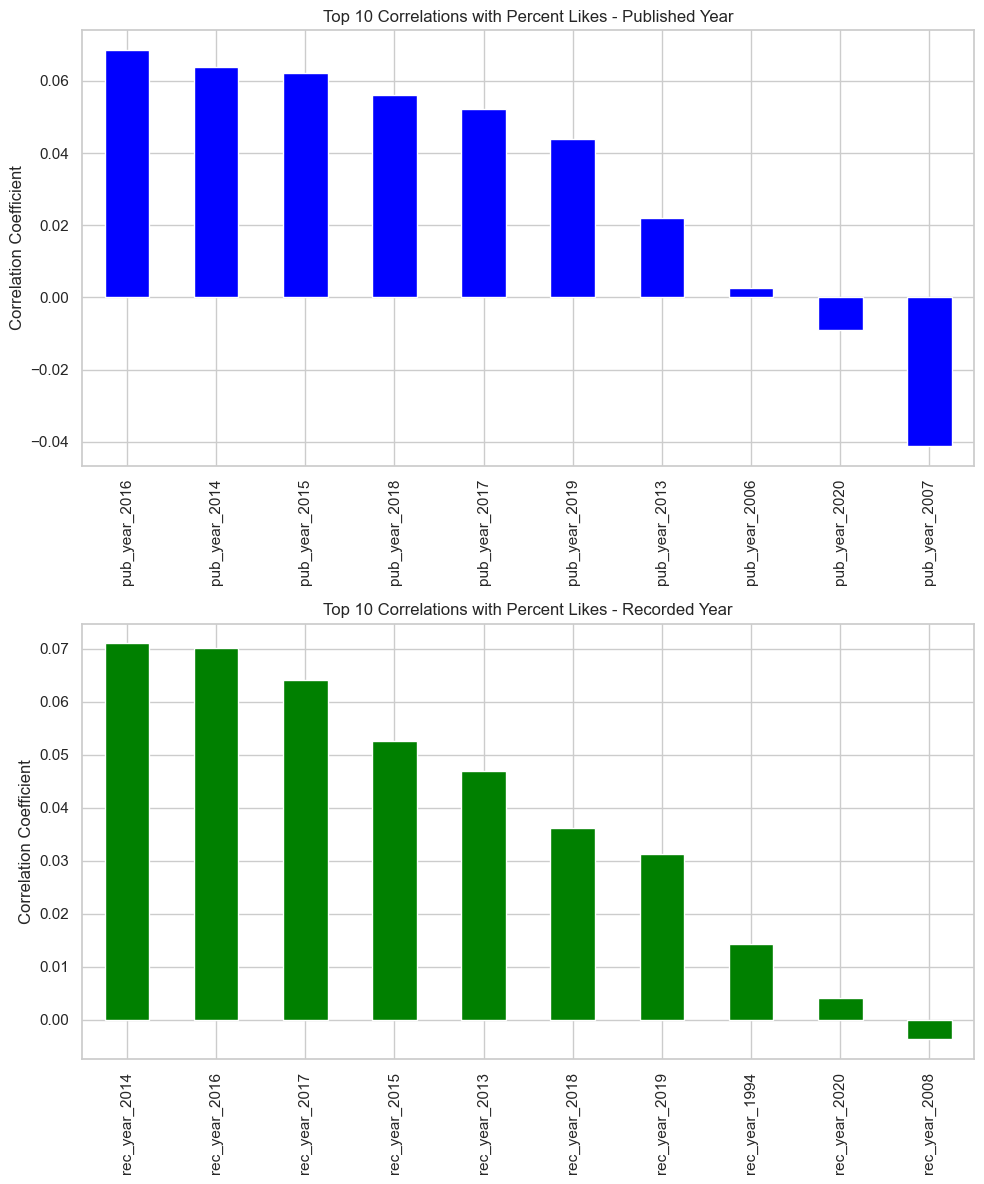

In [581]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your actual DataFrame here
# merged_cleaved_df = pd.read_csv('your_file.csv')

# Creating dummy variables for 'published_year' and 'recorded_year'
published_year_dummies = pd.get_dummies(merged_cleaved_df['published_year'], prefix='pub_year')
recorded_year_dummies = pd.get_dummies(merged_cleaved_df['recorded_year'], prefix='rec_year')

# Combining the dummy variables with 'percent_likes'
combined_df = pd.concat([merged_cleaved_df['percent_likes'], published_year_dummies, recorded_year_dummies], axis=1)

# Calculating the correlation
correlation = combined_df.corr()

# Extracting correlation with 'percent_likes' and removing the self-correlation
correlation_with_percent_likes = correlation['percent_likes'].drop('percent_likes', errors='ignore')

# Sorting the correlations to find the top ones
sorted_correlation = correlation_with_percent_likes.sort_values(ascending=False)

# Plotting the top correlations for 'published_year' and 'recorded_year'
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

# Top correlations for 'published_year'
top_published_year = sorted_correlation.filter(like='pub_year').head(10)
top_published_year.plot(kind='bar', ax=axes[0], color='blue')
axes[0].set_title('Top 10 Correlations with Percent Likes - Published Year')
axes[0].set_ylabel('Correlation Coefficient')

# Top correlations for 'recorded_year'
top_recorded_year = sorted_correlation.filter(like='rec_year').head(10)
top_recorded_year.plot(kind='bar', ax=axes[1], color='green')
axes[1].set_title('Top 10 Correlations with Percent Likes - Recorded Year')
axes[1].set_ylabel('Correlation Coefficient')

plt.tight_layout()
plt.show()


In [572]:
# Selecting the independent and dependent variables
X = merged_cleaved_df[['words_per_minute', 'questions_per_minute', 'laughs_per_minute']]
y = merged_cleaved_df['percent_likes']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creating the regression model
model = LinearRegression()

# Fitting the model
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
print("R^2 Score:", r2_score(y_test, y_pred))

# Displaying the coefficients
print("Coefficients:", model.coef_)


R^2 Score: -0.002807938339597804
Coefficients: [-0.03724797  0.08379417  0.12808963]


In [573]:
# creating a new column called 'good_speech' that is 1 if the talk is in the top 50% of percent_likes, and 0 if it is in the bottom 50% of percent_likes

# Calculate the 50th percentile (median) of the 'percent_likes' column
median_percent_likes = merged_cleaved_df['percent_likes'].median()

# Create the 'good_speech' column based on the condition
merged_cleaved_df['good_speech'] = (merged_cleaved_df['percent_likes'] >= median_percent_likes).astype(int)

# Now, merged_cleaved_df has a new column 'good_speech' with 1s and 0s based on the condition


In [574]:
X=merged_cleaved_df.drop("good_speech", axis=1)
y=merged_cleaved_df["good_speech"]

# train/test split should be conducted before Vectorization
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42) # If I add in stratify=y, will this mess up my re-joining of the X_train and X_test dataframes later on?


Creating a tokenizer and CountVectorizer for Transcripts:

In [575]:
from sklearn.feature_extraction import text 

# Custom stop words
custom_stop_words = ["laughter", "applause", "laughter applause", "--", "-"]

# Combine custom stop words with default English stop words
stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stop_words))

# As tokenizers must be functions, we will define a function for the tokenizer we will use
def nltk_tokenizer(text):
    # Remove punctuation using a list comprehension
    text_no_punctuation = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokenize the text without punctuation
    return word_tokenize(text_no_punctuation)

# instantiate CountVectorizer
bagofwords_transcript = CountVectorizer(stop_words=stop_words, # remove stop words
                                        tokenizer=nltk_tokenizer, # use the NLTK tokenizer
                                        min_df=10, # minimum document frequency of 10
                                        max_df=0.8, # maximum document frequency of 75% (i.e., ignore words that appear in more than 75% of the documents)
                                        ngram_range=(2, 3), # allowing for unigrams, bigrams, and trigrams
                                        max_features=100) # maximum number of features to keep

# Fit the CountVectorizer object on the positive (and, separately, negative) reviews
bagofwords_transcript.fit(X_train["transcript"])
print(bagofwords_transcript.fit(X_train["transcript"]))

/Users/drewe/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(max_df=0.8, max_features=100, min_df=10, ngram_range=(2, 3),
                stop_words=['thick', 'over', 'con', 'down', 'hundred', 'am',
                            'the', 'its', 'already', 'else', 'serious',
                            'within', 'seems', 'former', 'laughter applause',
                            'put', 'whereby', 're', 'nor', 'anyhow', 'through',
                            'i', 'those', 'might', 'towards', 'thus', 'yours',
                            'us', 'ten', 'only', ...],
                tokenizer=<function nltk_tokenizer at 0x2d9a30670>)


In [576]:
sparse_matrix_train = bagofwords_transcript.transform(X_train["transcript"])
sparse_matrix_test = bagofwords_transcript.transform(X_test["transcript"])

In [577]:
# Instantiate the Logistic Regression model
logreg = LogisticRegression(C = 0.01, max_iter=1000, n_jobs=-1) 

#Fit the model
logreg.fit(sparse_matrix_train, y_train)

# Training and test score
print(f"Train score: {logreg.score(sparse_matrix_train, y_train)}")
print(f"Test score: {logreg.score(sparse_matrix_test, y_test)}")

Train score: 0.5904654654654654
Test score: 0.5562218890554723


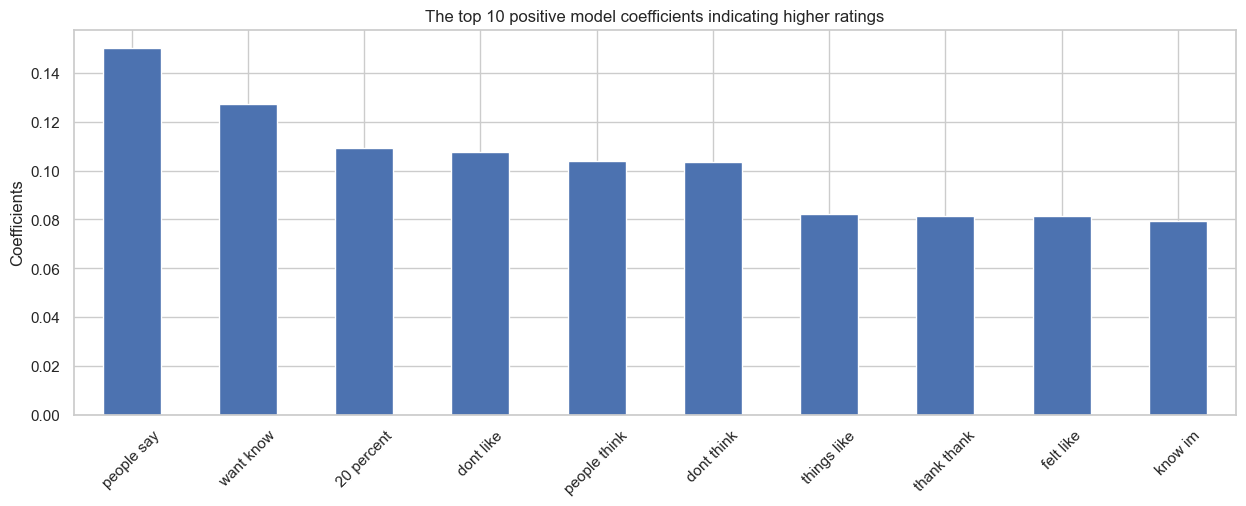

In [578]:
# Determining the top 20 coefficient words for positive reviews
# This code was adapted from BrainStation's Text Data lecture notebook
word_counts = pd.DataFrame(
    {"coefficients": logreg.coef_[0]},
    index=bagofwords_transcript.get_feature_names_out()
).sort_values("coefficients", ascending=False)

word_counts.head(10).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The top 10 positive model coefficients indicating higher ratings")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

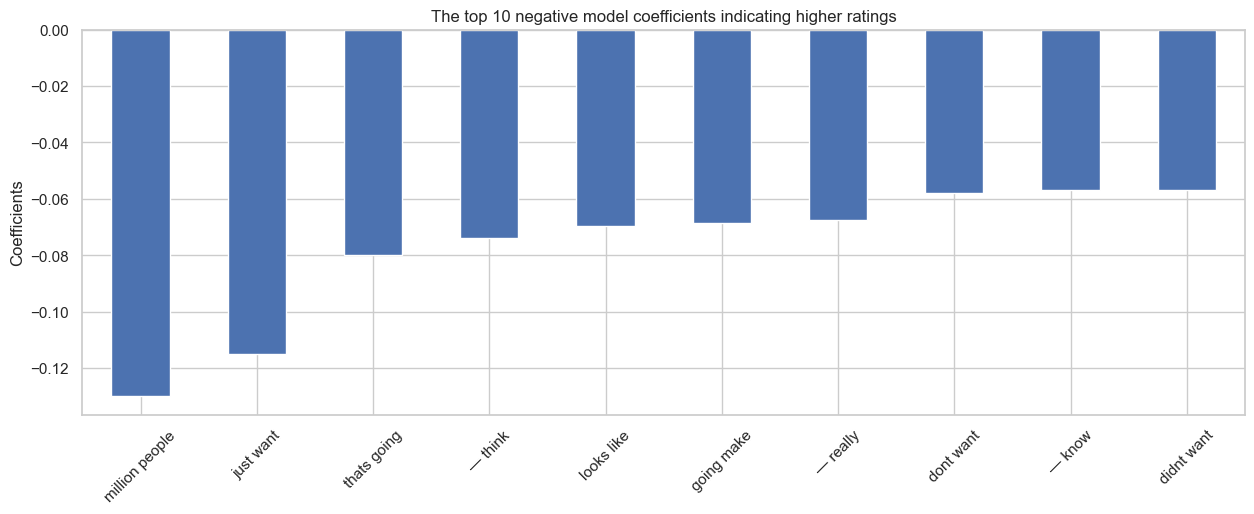

In [579]:
# Determining the top 20 coefficient words for positive reviews
# This code was adapted from BrainStation's Text Data lecture notebook
word_counts = pd.DataFrame(
    {"coefficients": logreg.coef_[0]},
    index=bagofwords_transcript.get_feature_names_out()
).sort_values("coefficients", ascending=True)

word_counts.head(10).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The top 10 negative model coefficients indicating higher ratings")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

In [ ]:
sparse_matrix_train_df = pd.DataFrame(data=sparse_matrix_train.toarray(), columns=bagofwords_transcript.get_feature_names_out(), index=X_train.index)
sparse_matrix_test_df = pd.DataFrame(data=sparse_matrix_test.toarray(), columns=bagofwords_transcript.get_feature_names_out(), index=X_test.index)

In [395]:
merged_cleaved_df

,talk_id,occupations,about_speakers,available_lang,comments,topics,related_talks,description,transcript,title,speaker,recorded_date,published_date,event,duration,...,likes,word_count,words_per_minute,percent_likes,ted_mainstage,transformed_occupations,published_year,published_month,recorded_year,recorded_month,num_question_marks,questions_per_minute,num_laughs,laughs_per_minute,good_speech
0,1,{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,"[alternative energy, cars, climate change, cul...","{243: 'New thinking on the climate crisis', 54...",With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre...",Averting the climate crisis,Al Gore,2006-02-25,2006-06-27,TED2006,957,...,110000,2153,0.539593,0.954200,1,climate_advocate,2006,6,2006,2,8,0.064179,22,0.297414,1
1,92,{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...","['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,"[Africa, Asia, Google, demo, economics, global...","{2056: ""Own your body's data"", 2296: 'A visual...",You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac...",The best stats you've ever seen,Hans Rosling,2006-02-22,2006-06-27,TED2006,1176,...,462000,3174,0.653271,0.975878,1,global_health_expert;_data_visionary,2006,6,2006,2,22,0.143625,9,0.099011,1
2,7,{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,"[computers, entertainment, interface design, m...","{1725: '10 top time-saving tech tips', 2274: '...",New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun...",Simplicity sells,David Pogue,2006-02-24,2006-06-27,TED2006,1266,...,60000,3371,0.642010,0.927845,1,technology_columnist,2006,6,2006,2,35,0.212251,38,0.388329,1
3,53,{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,"[MacArthur grant, activism, business, cities, ...",{1041: '3 stories of local eco-entrepreneurshi...,"In an emotionally charged talk, MacArthur-winn...",If you're here today — and I'm very happy that...,Greening the ghetto,Majora Carter,2006-02-26,2006-06-27,TED2006,1096,...,90000,3071,0.674009,0.976236,1,activist_for_environmental_justice,2006,6,2006,2,12,0.084059,10,0.118043,1
4,66,"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...","['af', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs...",4931.0,"[children, creativity, culture, dance, educati...","{865: 'Bring on the learning revolution!', 173...",Sir Ken Robinson makes an entertaining and pro...,Good morning. How are you? (Audience) Good. It...,Do schools kill creativity?,Sir Ken Robinson,2006-02-25,2006-06-27,TED2006,1151,...,2200000,3170,0.667039,0.907465,1,author educator,2006,6,2006,2,39,0.260138,40,0.449609,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3985,62628,{0: ['political strategist']},{0: 'A political strategist focused on creatin...,"['en', 'pt-br']",31.0,"[climate change, choice, leadership, society, ...",{2480: 'The inside story of the Paris climate ...,"When it comes to big life problems, we often s...",I never thought that I would be giving my TED ...,How to shift your mindset and choose your future,Tom Rivett-Carnac,2020-04-22,2020-04-22,TED2020,944,...,87000,2753,0.706859,0.906552,1,political_strategist,2020,4,2020,4,10,0.081329,0,0.000000,1
3986,62627,"{0: ['artist', 'storyteller']}","{0: 'With a style that crackles with wry wit, ...","['ar', 'en', 'fa', 'fr', 'tr']",12.0,"[Planets, art, poetry, life, love, empathy, hu...",{44696: 'You are not alone in your loneliness'...,If you had to explain to a newborn what it mea...,[Oliver Jeffers] [An ode to living on 

#### Addressing 'object' columns - changing them into numerical values, or dropping them altogether.

- all_speakers      3331 non-null   object **DROPPED**
- occupations       3331 non-null   object **ready for dummy variables**
- about_speakers    3331 non-null   object **ready for vectorization**
- native_lang       3331 non-null   object **DROPPED**
- available_lang    3331 non-null   object **Create dummies?**
- comments          3331 non-null   float64 **Ready for analysis**
- topics            3331 non-null   object **Create dummies?**
- related_talks     3331 non-null   object **CountVectorize?**
- url               3331 non-null   object **Dropped**
- description       3331 non-null   object **CountVectorize?**
- transcript        3331 non-null   object **CountVectorize?**
- title             3331 non-null   object **Dummy OR CountVectorize**?
- speaker           3331 non-null   object **Dummy OR CountVectorize**?
- recorded_date     3331 non-null   object **Changed to DateTime**
- published_date    3331 non-null   object **Changed to DateTime**
####  - event             3331 non-null   object **Ready for Dummies**

#### Additional Columns Created:
- published_year **ready for dummy variables**
- published_month **ready for dummy variables**
- recorded_year **ready for dummy variables**
- recorded_month **ready for dummy variables**
- percent_likes
- ted_mainstage 
- multiple_speakers 
- word_count
- words_minute
- transformed_occupations **ready for dummy variables**

In [278]:
merged_cleaved_df

,talk_id,occupations,about_speakers,available_lang,comments,topics,related_talks,description,transcript,title,speaker,recorded_date,published_date,event,duration,views,likes,word_count,words_per_minute,percent_likes,ted_mainstage,transformed_occupations,published_year,published_month,recorded_year,recorded_month
0,1,{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre...",Averting the climate crisis,Al Gore,2006-02-25,2006-06-27,TED2006,957,3681537,110000,2153,2.203685,0.029879,1,climate_advocate,2006,6,2006,2
1,92,{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...","['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac...",The best stats you've ever seen,Hans Rosling,2006-02-22,2006-06-27,TED2006,1176,15432904,462000,3174,2.667227,0.029936,1,global_health_expert;_data_visionary,2006,6,2006,2
2,7,{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun...",Simplicity sells,David Pogue,2006-02-24,2006-06-27,TED2006,1266,2012797,60000,3371,2.621306,0.029809,1,technology_columnist,2006,6,2006,2
3,53,{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,"['MacArthur grant', 'activism', 'business', 'c...",{1041: '3 stories of local eco-entrepreneurshi...,"In an emotionally charged talk, MacArthur-winn...",If you're here today — and I'm very happy that...,Greening the ghetto,Majora Carter,2006-02-26,2006-06-27,TED2006,1096,3006315,90000,3071,2.751792,0.029937,1,activist_for_environmental_justice,2006,6,2006,2
4,66,"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...","['af', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs...",4931.0,"['children', 'creativity', 'culture', 'dance',...","{865: 'Bring on the learning revolution!', 173...",Sir Ken Robinson makes an entertaining and pro...,Good morning. How are you? (Audience) Good. It...,Do schools kill creativity?,Sir Ken Robinson,2006-02-25,2006-06-27,TED2006,1151,73935964,2200000,3170,2.723368,0.029755,1,author educator,2006,6,2006,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3985,62628,{0: ['political strategist']},{0: 'A political strategist focused on creatin...,"['en', 'pt-br']",31.0,"['climate change', 'choice', 'leadership', 'so...",{2480: 'The inside story of the Paris climate ...,"When it comes to big life problems, we often s...",I never thought that I would be giving my TED ...,How to shift your mindset and choose your future,Tom Rivett-Carnac,2020-04-22,2020-04-22,TED2020,944,2924068,87000,2753,2.885744,0.029753,1,political_strategist,2020,4,2020,4
3986,62627,"{0: ['artist', 'storyteller']}","{0: 'With a style that crackles with wry wit, ...","['ar', 'en', 'fa', 'fr', 'tr']",12.0,"['Planets', 'art', 'poetry', 'life', 'love', '...",{44696: 'You are not alone in your loneliness'...,If you had to explain to a newborn what it mea...,[Oliver Jeffers] [An ode to living on Earth] H...,An ode to living on Earth,Oliver Jeffers,2020-04-22,2020-04-22,TED2020,628,2220268,66000,1860,2.879257,0.029726,1,artist storyteller,2020,4,2020,4
3990,62748,"{0: ['epidemiologist', 'philanthropist'], 1: [...","{0:

## Next Steps:

Create dummy variables where possible.
- event  **Ready for Dummies**
- published_year **ready for dummy variables**
- published_month **ready for dummy variables**
- recorded_year **ready for dummy variables**
- recorded_month **ready for dummy variables**
- transformed_occupations **ready for dummy variables**


Scale my dependent variable of "percent-likes"
scale other non-dummy-variable columns
- comments
- views
- duration
- word_count
- words_minute

Drop the "likes" column, as it will correlate too strongly with 'percent_likes'.



For Future Consideration:
- available_lang    3331 non-null   object **Create dummies?** *temporarily drop*
- topics            3331 non-null   object **Create dummies?**
- related_talks     3331 non-null   object **CountVectorize?**
- description       3331 non-null   object **CountVectorize?**
- transcript        3331 non-null   object **CountVectorize?**
- title             3331 non-null   object **Dummy OR CountVectorize**?
- speaker           3331 non-null   object **Dummy OR CountVectorize**?


## Creating Dummy Variables:


In [230]:
merged_cleaved_df

,talk_id,occupations,about_speakers,available_lang,comments,topics,related_talks,description,transcript,title,recorded_date,published_date,duration,views,word_count,...,speaker_Zachary R. Wood,speaker_Zahra' Langhi,speaker_Zainab Salbi,speaker_Zak Ebrahim,speaker_Zaria Forman,speaker_Ze Frank,speaker_Zeresenay Alemseged,speaker_Zeynep Tufekci,speaker_Ziauddin Yousafzai,speaker_Ziyah Gafić,speaker_Zubaida Bai,speaker_eL Seed,speaker_iO Tillett Wright,speaker_tobacco brown,speaker_Özlem Cekic
0,1,{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre...",Averting the climate crisis,2006-02-25,2006-06-27,957,3681537,2153,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,92,{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...","['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac...",The best stats you've ever seen,2006-02-22,2006-06-27,1176,15432904,3174,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,7,{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun...",Simplicity sells,2006-02-24,2006-06-27,1266,2012797,3371,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,53,{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,"['MacArthur grant', 'activism', 'business', 'c...",{1041: '3 stories of local eco-entrepreneurshi...,"In an emotionally charged talk, MacArthur-winn...",If you're here today — and I'm very happy that...,Greening the ghetto,2006-02-26,2006-06-27,1096,3006315,3071,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,66,"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...","['af', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs...",4931.0,"['children', 'creativity', 'culture', 'dance',...","{865: 'Bring on the learning revolution!', 173...",Sir Ken Robinson makes an entertaining and pro...,Good morning. How are you? (Audience) Good. It...,Do schools kill creativity?,2006-02-25,2006-06-27,1151,73935964,3170,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3985,62628,{0: ['political strategist']},{0: 'A political strategist focused on creatin...,"['en', 'pt-br']",31.0,"['climate change', 'choice', 'leadership', 'so...",{2480: 'The inside story of the Paris climate ...,"When it comes to big life problems, we often s...",I never thought that I would be giving my TED ...,How to shift your mindset and choose your future,2020-04-22,2020-04-22,944,2924068,2753,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3986,62627,"{0: ['artist', 'storyteller']}","{0: 'With a style that crackles with wry wit, ...","['ar', 'en', 'fa', 'fr', 'tr']",12.0,"['Planets', 'art', 'poetry', 'life', 'love', '...",{44696: 'You are not alone in your loneliness'...,If you had to explain to a newborn what it mea...,[Oliver Jeffers] [

In [279]:
# List of columns for which to create dummy variables
columns_to_dummify = [
    'event',
    'published_year',
    'published_month',
    'recorded_year',
    'recorded_month',
    'transformed_occupations'
]

# Creating dummy variables
for column in columns_to_dummify:
    dummies = pd.get_dummies(merged_cleaved_df[column], prefix=column)
    merged_cleaved_df = pd.concat([merged_cleaved_df, dummies], axis=1)
    merged_cleaved_df.drop(column, axis=1, inplace=True)

In [280]:
merged_cleaved_df

,talk_id,occupations,about_speakers,available_lang,comments,topics,related_talks,description,transcript,title,speaker,recorded_date,published_date,duration,views,...,transformed_occupations_writer youth_worker freedom_fighter,transformed_occupations_writer_and_editor,transformed_occupations_writer_and_philosopher,transformed_occupations_writer_and_poet,transformed_occupations_writer_and_radio_host,transformed_occupations_writer_and_radio_producer,transformed_occupations_wrongologist,transformed_occupations_x-ray_visionary,transformed_occupations_yo-yo_champion,transformed_occupations_yogurt_maker humanitarian,transformed_occupations_youth_inventor,transformed_occupations_youtube_educator,transformed_occupations_zoologist,transformed_occupations_zoologist author explorer,transformed_occupations_zoologist venom_researcher
0,1,{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre...",Averting the climate crisis,Al Gore,2006-02-25,2006-06-27,957,3681537,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,92,{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...","['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac...",The best stats you've ever seen,Hans Rosling,2006-02-22,2006-06-27,1176,15432904,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,7,{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun...",Simplicity sells,David Pogue,2006-02-24,2006-06-27,1266,2012797,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,53,{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,"['MacArthur grant', 'activism', 'business', 'c...",{1041: '3 stories of local eco-entrepreneurshi...,"In an emotionally charged talk, MacArthur-winn...",If you're here today — and I'm very happy that...,Greening the ghetto,Majora Carter,2006-02-26,2006-06-27,1096,3006315,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,66,"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...","['af', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs...",4931.0,"['children', 'creativity', 'culture', 'dance',...","{865: 'Bring on the learning revolution!', 173...",Sir Ken Robinson makes an entertaining and pro...,Good morning. How are you? (Audience) Good. It...,Do schools kill creativity?,Sir Ken Robinson,2006-02-25,2006-06-27,1151,73935964,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3985,62628,{0: ['political strategist']},{0: 'A political strategist focused on creatin...,"['en', 'pt-br']",31.0,"['climate change', 'choice', 'leadership', 'so...",{2480: 'The inside story of the Paris climate ...,"When it comes to big life problems, we often s...",I never thought that I would be giving my TED ...,How to shift your mindset and choose your future,Tom Rivett-Carnac,2020-04-22,2020-04-22,944,2924068,...,False,F

In [228]:
# Dropping the "likes" column
merged_cleaved_df.drop(["likes"], axis=1, inplace=True)

# Creating a Temporary EDA DataFrame for only the numerical values that we have thus far:

This means dropping the following columns:
    'talk_id',
    'occupations',
    'about_speakers',
    'available_lang',
    'topics',
    'related_talks',
    'description',
    'transcript',
    'title',
    'speaker'

In [288]:
# List of columns to drop
columns_to_drop = [
    'talk_id',
    'occupations',
    'about_speakers',
    'available_lang',
    'topics',
    'related_talks',
    'description',
    'transcript',
    'title',
    'speaker',
    'published_date',
    'recorded_date'
]

# Creating a new DataFrame by dropping specified columns
numeric_temp_df = merged_cleaved_df.drop(columns=columns_to_drop)
numeric_temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3331 entries, 0 to 3993
Columns: 2427 entries, comments to transformed_occupations_zoologist venom_researcher
dtypes: bool(2419), float64(3), int64(5)
memory usage: 7.9 MB


We now have a temporary dataframe called "numeric_temp_df" with which we can run a linear regression against our dependent variable "percent_likes"

In [290]:
# Assuming your DataFrame is named numeric_temp_df and 'percent_likes' is your target variable
X = numeric_temp_df.drop('percent_likes', axis=1)  # Features (all columns except 'percent_likes')
y = numeric_temp_df['percent_likes']  # Target variable

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Standard Scaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing data (do not fit the scaler again!)
X_test_scaled = scaler.transform(X_test)

# Initialize the Linear Regression model
model = LinearRegression(n_jobs=-1)

# Fit the model on the scaled training data
model.fit(X_train_scaled, y_train)

# Now you can use model.predict(X_test_scaled) to make predictions on your test set

LinearRegression(n_jobs=-1)

In [293]:
# 1. Calculate Accuracy Scores
# Predict on training and testing data
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Calculate R² score for training and testing sets
r2_score_train = r2_score(y_train, y_train_pred)
r2_score_test = r2_score(y_test, y_test_pred)

print("R² score for training set:", r2_score_train)
print("R² score for testing set:", r2_score_test)

# 2. Identify Top 50 Positive and Negative Coefficients
# Get the coefficients from the model and create a Series with column names
coefficients = pd.Series(model.coef_, index=X.columns)

# Sort the coefficients
sorted_coefficients = coefficients.sort_values()

# Top 50 negative coefficients
top_50_negative = sorted_coefficients.head(50)

# Top 50 positive coefficients
top_50_positive = sorted_coefficients.tail(50).sort_values(ascending=False)

print("Top 50 positive coefficients:\n", top_50_positive)
print("\nTop 50 negative coefficients:\n", top_50_negative)

R² score for training set: -18.790095557128765
R² score for testing set: -7.691158178931667e+27
Top 50 positive coefficients:
 transformed_occupations_physician scientist          1.688509e+10
transformed_occupations_open-government_expert       1.612440e+10
transformed_occupations_healthcare_innovator         1.572889e+10
transformed_occupations_science_advocate             1.474389e+10
transformed_occupations_gardening_activist           1.455860e+10
                                                         ...     
event_TEDxLivoniaCCLibrary                           7.458801e+09
transformed_occupations_clinical_professor_of_law    7.329223e+09
transformed_occupations_tech_publisher               7.263795e+09
event_TED2006                                        7.112547e+09
transformed_occupations_a_capella_ensemble           6.911465e+09
Length: 50, dtype: float64

Top 50 negative coefficients:
 transformed_occupations_spinal_cord_researcher             -2.108290e+10
transformed_occ

## Next Steps:

Let's look at the distribution of the column "percent_likes" to see if we can determine which talks are "great" talks and which ones are not.

We will then create a binary variable at this level, and then run a logistic regression against this target variable.

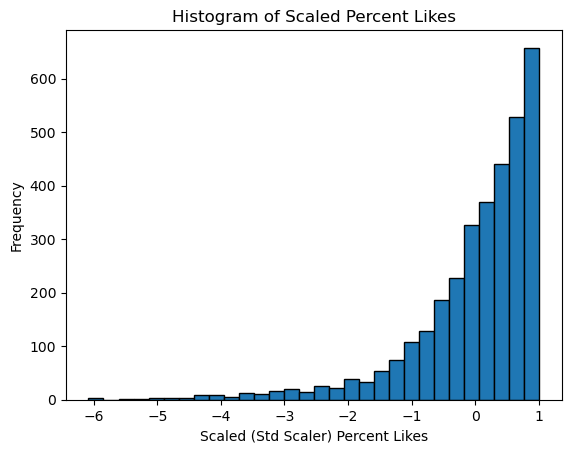

In [297]:
# Extracting the 'percent_likes' column
percent_likes = numeric_temp_df[['percent_likes']]

# Initialize the Standard Scaler
scaler = StandardScaler()

# Scale the 'percent_likes' column
percent_likes_scaled = scaler.fit_transform(percent_likes)

# Now, percent_likes_scaled contains the scaled values of the 'percent_likes' column

# Plotting the histogram of the scaled 'percent_likes' data
plt.hist(percent_likes_scaled, bins=30, edgecolor='black')
plt.title('Histogram of Scaled Percent Likes')
plt.xlabel('Scaled (Std Scaler) Percent Likes')
plt.ylabel('Frequency')
plt.show()

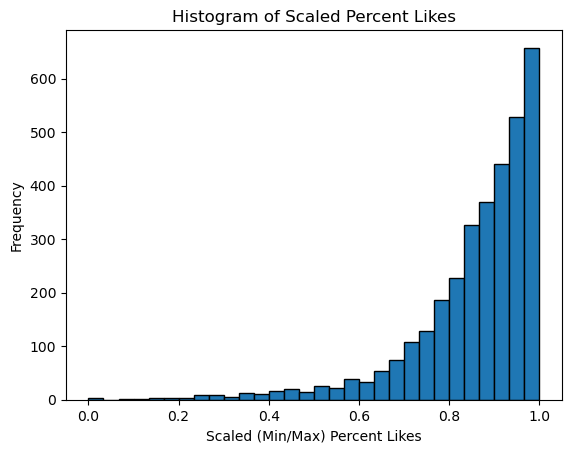

In [298]:
# Extracting the 'percent_likes' column
percent_likes = numeric_temp_df[['percent_likes']]

# Initialize the Standard Scaler
scaler = MinMaxScaler()

# Scale the 'percent_likes' column
percent_likes_scaled = scaler.fit_transform(percent_likes)

# Now, percent_likes_scaled contains the scaled values of the 'percent_likes' column

# Plotting the histogram of the scaled 'percent_likes' data
plt.hist(percent_likes_scaled, bins=30, edgecolor='black')
plt.title('Histogram of Scaled Percent Likes')
plt.xlabel('Scaled (Min/Max) Percent Likes')
plt.ylabel('Frequency')
plt.show()

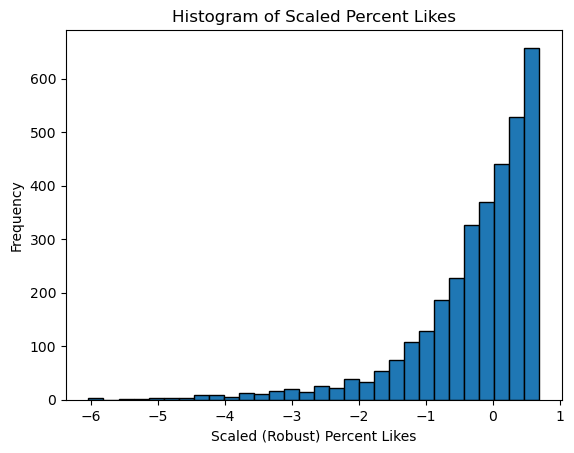

In [299]:
# Extracting the 'percent_likes' column
percent_likes = numeric_temp_df[['percent_likes']]

# Initialize the Standard Scaler
scaler = RobustScaler()

# Scale the 'percent_likes' column
percent_likes_scaled = scaler.fit_transform(percent_likes)

# Now, percent_likes_scaled contains the scaled values of the 'percent_likes' column

# Plotting the histogram of the scaled 'percent_likes' data
plt.hist(percent_likes_scaled, bins=30, edgecolor='black')
plt.title('Histogram of Scaled Percent Likes')
plt.xlabel('Scaled (Robust) Percent Likes')
plt.ylabel('Frequency')
plt.show()

In [313]:
pd.options.display.max_rows = 40
pd.options.display.max_columns = 30
pd.options.display.max_colwidth = 20


In [305]:
print(transcript_df["transcript"][:1])

0    Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful. I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night. And I say that sincerely, partly because (Mock sob) I need that. (Laughter) Put yourselves in my position. (Laughter) I flew on Air Force Two for eight years. (Laughter) Now I have to take off my shoes or boots to get on an airplane! (Laughter) (Applause) I'll tell you one quick story to illustrate what that's been like for me. (Laughter) It's a true story — every bit of this is true. Soon after Tipper and I left the — (Mock sob) White House — (Laughter) we were driving from our home in Nashville to a little farm we have 50 miles east of Nashville. Driving ourselves. (Laughter) I know it sounds like a little thing to you, but — (Laughter) I looked in the rear-view mirror and all of a sudden it just hit me. There

Here we're going to create numerical columns called "questions_per_minute" and "laughs_per_minute".

In [316]:
# Define a function that counts question marks in a given string
def count_question_marks(text):
    return text.count('?')

# Apply this function to each row of the 'transcript' column and store the result in a new column
transcript_df['num_question_marks'] = transcript_df['transcript'].apply(count_question_marks)
transcript_df['questions_per_minute'] = transcript_df['num_question_marks'] / transcript_df['duration']
transcript_df.head(3)

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript,num_question_marks,num_laughs,questions_per_minute,laughs_per_minute
0,1,Averting the cli...,Al Gore,{0: 'Al Gore'},{0: ['climate ad...,{0: 'Nobel Laure...,3523392,2006-02-25,2006-06-27,TED2006,en,"['ar', 'bg', 'cs...",272.0,977,['alternative en...,{243: 'New think...,https://www.ted....,With the same hu...,Thank you so muc...,8,22,0.008188,0.022518
1,92,The best stats y...,Hans Rosling,{0: 'Hans Rosling'},{0: ['global hea...,{0: 'In Hans Ros...,14501685,2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg...",628.0,1190,"['Africa', 'Asia...","{2056: ""Own your...",https://www.ted....,You've never see...,About 10 years a...,22,9,0.018487,0.007563
2,7,Simplicity sells,David Pogue,{0: 'David Pogue'},{0: ['technology...,{0: 'David Pogue...,1920832,2006-02-24,2006-06-27,TED2006,en,"['ar', 'bg', 'de...",124.0,1286,"['computers', 'e...",{1725: '10 top t...,https://www.ted....,New York Times c...,"(Music: ""The Sou...",35,38,0.027216,0.029549


In [315]:
# Create a function that counts the number of "(Laughter)" in a string.
def count_laughter(text):
    # Splitting the text into words and count them
    return text.count("(Laughter)")

# Apply this function to each row of the 'transcript' column and store the result in a new column
transcript_df['num_laughs'] = transcript_df['transcript'].apply(count_laughter)
transcript_df['laughs_per_minute'] = transcript_df['num_laughs'] / transcript_df['duration']

In [224]:
merged_cleaved_df["event"].value_counts()

event
TED2017                    96
TED2018                    95
TED2019                    91
TED2014                    83
TED2009                    80
                           ..
TEDxBG                      1
TEDxIndianapolis            1
TEDxChapmanU                1
TEDxGoldenGatePark 2012     1
TEDxCreativeCoast           1
Name: count, Length: 432, dtype: int64

This column is ready for dummy variables.

In [10]:
# How many unique values are in each column?

for col in df1.columns:
    selected = df1[col]
    n_unique = selected.unique().shape[0]
    print(" Column {:40s} has {:6d} unique values".format(col,n_unique))

 Column talk_id                                  has   4005 unique values
 Column title                                    has   4005 unique values
 Column speaker_1                                has   3274 unique values
 Column all_speakers                             has   3307 unique values
 Column occupations                              has   2050 unique values
 Column about_speakers                           has   2978 unique values
 Column views                                    has   3996 unique values
 Column recorded_date                            has   1335 unique values
 Column published_date                           has   2962 unique values
 Column event                                    has    459 unique values
 Column native_lang                              has     12 unique values
 Column available_lang                           has   3902 unique values
 Column comments                                 has    602 unique values
 Column duration                      

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4005 entries, 0 to 4004
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   talk_id         4005 non-null   int64  
 1   title           4005 non-null   object 
 2   speaker_1       4005 non-null   object 
 3   all_speakers    4001 non-null   object 
 4   occupations     3483 non-null   object 
 5   about_speakers  3502 non-null   object 
 6   views           4005 non-null   int64  
 7   recorded_date   4004 non-null   object 
 8   published_date  4005 non-null   object 
 9   event           4005 non-null   object 
 10  native_lang     4005 non-null   object 
 11  available_lang  4005 non-null   object 
 12  comments        3350 non-null   float64
 13  duration        4005 non-null   int64  
 14  topics          4005 non-null   object 
 15  related_talks   4005 non-null   object 
 16  url             4005 non-null   object 
 17  description     4005 non-null   o

In [19]:
# Assign new text to the 'transcript' column of row 579
df1.at[579, 'transcript'] = "Right now is the most exciting time to see new Indian art. Contemporary artists.... (Applause)"
df1.at[579, 'description'] = "Collector Ravin Agrawal delivers a glowing introduction to 10 of India's most exciting..."

# Now you can proceed with your existing code to display the row
row = df1.iloc[579]
markdown_table = row.to_frame().T.to_markdown(index=False)
print(markdown_table)


|   talk_id | title                            | speaker_1     | all_speakers         | occupations       | about_speakers                                                                                                                               |   views | recorded_date   | published_date   | event         | native_lang   | available_lang                                                                                                                                                  |   comments |   duration | topics                                       | related_talks                                                                                                                                                                                                                   | url                                                                       | description                                                                               | transcript                               

In [11]:
# Select the first row (you can change the row index as needed)
row = df1.iloc[579]

# Convert the row to markdown table format
markdown_table = row.to_frame().T.to_markdown(index=False)

# Print the markdown table
print(markdown_table)

|   talk_id | title                            | speaker_1     | all_speakers         | occupations       | about_speakers                                                                                                                               |   views | recorded_date   | published_date   | event         | native_lang   | available_lang                                                                                                                                                  |   comments |   duration | topics                                       | related_talks                                                                                                                                                                                                                   | url                                                                       | description                                                                                                                          

In [ ]:
# the most recent published date was 2022-10-13.  This information is used to determine when the last update of each video's view and likes was made.  
sorted_df_by_published_date = df1.sort_values(by='published_date', ascending=False)

In [18]:
# the most recent published date was 2022-10-13.  This information is used to determine when the last update of each video's view and likes was made.  
sorted_df_by_published_date = df1.sort_values(by='published_date', ascending=False)
sorted_df_by_published_date


,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript
4004,62794,The most important anus in the ocean,Cella Wright,{0: 'Cella Wright'},NaN,NaN,0,2020-04-30,2020-04-30,TED-Ed,en,['en'],NaN,281,"['animals', 'TED-Ed', 'animation', 'oceans', '...","{62347: 'The bug that poops candy', 29159: 'In...",https://www.ted.com/talks/cella_wright_the_mos...,Is it a fuzzy sock? An overripe banana? A mold...,Can you guess what you’re looking at? Is it a ...
4003,62784,The electrifying speeches of Sojourner Truth,Daina Ramey Berry,{0: 'Daina Ramey Berry'},NaN,NaN,56582,2020-04-28,2020-04-30,TED-Ed,en,['en'],NaN,257,"['TED-Ed', 'education', 'animation', 'United S...",{20973: 'The breathtaking courage of Harriet T...,https://www.ted.com/talks/daina_ramey_berry_th...,Isabella Baumfree was born into slavery in lat...,"In early 1828, Sojourner Truth approached the ..."
4002,62263,"How ""policing for profit"" undermines your rights",Dick M. Carpenter II,{0: 'Dick M. Carpenter II'},{0: ['law researcher']},{0: 'Dick M. Carpenter II studies cutting edge...,464414,2019-06-22,2020-04-28,TEDxMileHigh,en,['en'],9.0,774,"['society', 'law', 'policy', 'justice system',...","{2406: 'I love being a police officer, but we ...",https://www.ted.com/talks/dick_m_carpenter_ii_...,"Many countries have an active, centuries-old l...",Picture yourself driving down the road tomorro...
4001,62782,The dark history of IQ tests,Stefan C Dombrowski,{0: 'Stefan C Dombrowski'},NaN,NaN,307187,2020-04-27,2020-04-27,TED-Ed,en,"['en', 'es', 'my', 'pt-br']",NaN,346,"['TED-Ed', 'education', 'history', 'animation'...",{35386: 'How does the Rorschach inkblot test w...,https://www.ted.com/talks/stefan_c_dombrowski_...,"In 1905, psychologists Alfred Binet and Théodo...","In 1905, psychologists Alfred Binet and Théodo..."
4000,62678,"Crisis support for the world, one text away",Nancy Lublin,{0: 'Nancy Lublin'},{0: ['health activist']},"{0: 'Nancy Lublin, cofounder and CEO of Crisis...",502934,2020-04-22,2020-04-27,TED2020: The Prequel,en,['en'],6.0,690,"['activism', 'data', 'technology', 'mental hea...",{2362: 'How data from a crisis text line is sa...,https://www.ted.com/talks/nancy_lublin_crisis_...,What if we could help people in crisis anytime...,"""I'm 14, and I want to go home."" ""My name is B..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,53,Greening the ghetto,Majora Carter,{0: 'Majora Carter'},{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,2664069,2006-02-26,2006-06-27,TED2006,en,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,1116,"['MacArthur grant', 'activism', 'business', 'c...",{1041: '3 stories of local eco-entrepreneurshi...,https://www.ted.com/talks/majora_carter_greeni...,"In an emotionally charged talk, MacArthur-winn...",If you're here today — and I'm very happy that...
2,7,Simplicity sells,David Pogue,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,1920832,2006-02-24,2006-06-27,TED2006,en,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,1286,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",https://www.ted.com/talks/david_pogue_simplici...,New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun..."
1,92,The best stats you've ever seen,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",14501685,2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,1190,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,You've never seen data presented like this. Wi...,"About 

In [6]:
# Select the first row (you can change the row index as needed)
row = df1.iloc[579]

# Convert the row to markdown table format
markdown_table = row.to_frame().T.to_markdown(index=False)

# Print the markdown table
print(markdown_table)

|   talk_id | title                      | speaker          | recorded_date   | published_date   | event          |   duration |   views |   likes |
|----------:|:---------------------------|:-----------------|:----------------|:-----------------|:---------------|-----------:|--------:|--------:|
|       723 | My solar-powered adventure | Bertrand Piccard | 2009-07-24      | 2010-01-01       | TEDGlobal 2009 |       1049 |  903784 |   27000 |


In [8]:
df1["event"].nunique

<bound method IndexOpsMixin.nunique of 0                              TED2006
1                              TED2006
2                              TED2006
3                              TED2006
4                              TED2006
                     ...              
5696                            TED-Ed
5697          TED Salon Bezos Scholars
5698    Body Stuff with Dr. Jen Gunter
5699                            TED-Ed
5700                        TEDxSurrey
Name: event, Length: 5701, dtype: object>

In [12]:
#Changing DateTime columns to DateTime

df1["date"] = pd.to_datetime(df1["date"])

/var/folders/l2/d5ln4l29453322fq40g1dz2h0000gn/T/ipykernel_72805/4165279598.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1["date"] = pd.to_datetime(df1["date"])


In [180]:
df1["event"].value_counts()

event
TED-Ed               890
TED2018              104
TED2020              102
TED2019              101
TED2017               97
                    ... 
TEDxEastEnd            1
TEDActive 2015         1
Global Witness         1
TEDxCreativeCoast      1
TEDxSurrey             1
Name: count, Length: 637, dtype: int64

## Null Imputing

In [39]:
# Null Imputing = the only two nulls here are from 2020 events.  I am going to impute them with '2020-07-24' (see next block of code), which is a day that TED 2020 was hosted on.
rows_with_null_as_recorded_date = df1[df1["recorded_date"].isna()]
rows_with_null_as_recorded_date

,talk_id,title,speaker,recorded_date,published_date,event,duration,views,likes


In [36]:
# imputing nulls - Adding the recorded_date to the Debbie Millman speech.  This event was over a 1.5 month long period in 2020, which included the published date (the date I'm using to impute)
df1.loc[df1['talk_id'] == 65384, 'recorded_date'] = '2020-07-24'

In [38]:
# I'm imputing e Bearutyrest missing recorded date with it's published date.
df1.loc[df1['talk_id'] == 65233, 'recorded_date'] = '2020-07-29'

In [59]:
# I'm dropping the other nulls as they represent too few datapoints (2 out of 5701)
df1.dropna(inplace=True)
df1.info()

,talk_id,title,speaker,recorded_date,published_date,event,duration,views,likes,published_year,published_month,recorded_year,recorded_month,percent_likes
5606,94839,"How ""dilemma thinking"" transforms argument int...",Countdown,2022-06-16,2022-07-08,NaN,223,14028,420,2022,7,2022,6,2.994012


There are no more null values in the dataset.

In [75]:
df1.isna().sum()

talk_id            0
title              0
speaker            0
recorded_date      0
published_date     0
event              0
duration           0
views              0
likes              0
published_year     0
published_month    0
recorded_year      0
recorded_month     0
percent_likes      0
dtype: int64

In [128]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5699 entries, 0 to 5700
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   talk_id          5699 non-null   int64         
 1   title            5699 non-null   object        
 2   speaker          5699 non-null   object        
 3   recorded_date    5699 non-null   datetime64[ns]
 4   published_date   5699 non-null   datetime64[ns]
 5   event            5699 non-null   object        
 6   duration         5699 non-null   int64         
 7   views            5699 non-null   int64         
 8   likes            5699 non-null   int64         
 9   published_year   5699 non-null   int32         
 10  published_month  5699 non-null   int32         
 11  recorded_year    5699 non-null   int32         
 12  recorded_month   5699 non-null   int32         
 13  percent_likes    5699 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int32(4), i

## Creating Additional Columns:

- published_year
- published_month
- recorded_year
- recorded_month
- percent_likes

In [42]:
# Creating a "published_year" "published_month" "recorded_date" and "recorded_month" columns

df1["published_year"] = df1["published_date"].dt.year
df1["published_month"] = df1["published_date"].dt.month
df1["recorded_year"] = df1["recorded_date"].dt.year
df1["recorded_month"] = df1["recorded_date"].dt.month

In [43]:
# Creating a "percent_likes" column

df1["percent_likes"] = (df1["likes"] / df1["views"]) * 100
df1

,talk_id,title,speaker,recorded_date,published_date,event,duration,views,likes,published_year,published_month,recorded_year,recorded_month,percent_likes
0,1,Averting the climate crisis,Al Gore,2006-02-25,2006-06-27,TED2006,957,3681537,110000,2006,6,2006,2,2.987883
1,7,Simplicity sells,David Pogue,2006-02-24,2006-06-27,TED2006,1266,2012797,60000,2006,6,2006,2,2.980927
2,53,Greening the ghetto,Majora Carter,2006-02-26,2006-06-27,TED2006,1096,3006315,90000,2006,6,2006,2,2.993698
3,92,The best stats you've ever seen,Hans Rosling,2006-02-22,2006-06-27,TED2006,1176,15432904,462000,2006,6,2006,2,2.993604
4,66,Do schools kill creativity?,Sir Ken Robinson,2006-02-25,2006-06-27,TED2006,1151,73935964,2200000,2006,6,2006,2,2.975548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5696,98707,Is inequality inevitable?,TED-Ed,2022-10-11,2022-10-11,TED-Ed,390,109948,3200,2022,10,2022,10,2.910467
5697,98662,4 ways to design a disability-friendly future,Meghan Hussey,2022-09-08,2022-10-11,TED Salon Bezos Scholars,544,310241,9300,2022,10,2022,9,2.997670
5698,98383,"Can exercise actually ""boost"" your metabolism?",Jen Gunter,2022-10-12,2022-10-12,Body Stuff with Dr. Jen Gunter,210,30087,902,2022,10,2022,10,2.997973
5699,98706,How did they build the Great Pyramid of Giza?,Soraya Field Fiorio,2022-10-13,2022-10-13,TED-Ed,332,456,13,2022,10,2022,10,2.850877


In [ ]:
How are VIEWS Distributed across:
- Year published
- Year recorded
- Month Published
- Month recorded
- Event 

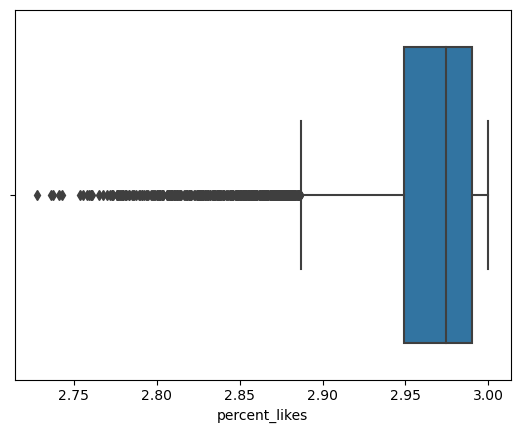

In [129]:
# the percent of "likes" is heavily distributed towards 3%, 

sns.boxplot(data=df1, x="percent_likes")
plt.show()

## Most percent_likes are close to 3%

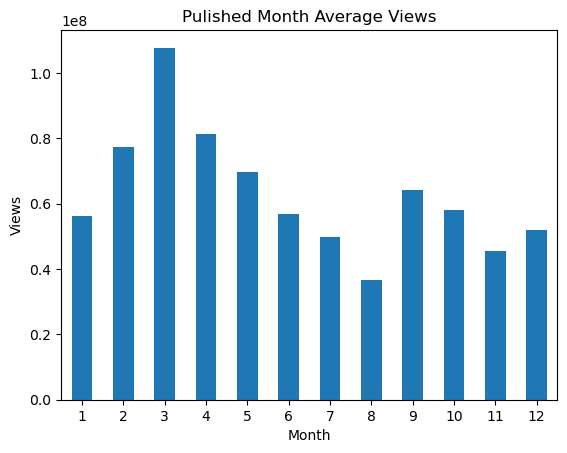

In [126]:
# Monthly average of views by publishing month

monthly_average_pub = df1.groupby(["published_year", "published_month"])["views"].sum()
cross_year_average_pub = monthly_average_pub.groupby("published_month").mean()
cross_year_average_pub
cross_year_average_pub.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Views')
plt.title('Pulished Month, Average Views')
plt.xticks(rotation=0)
plt.show()

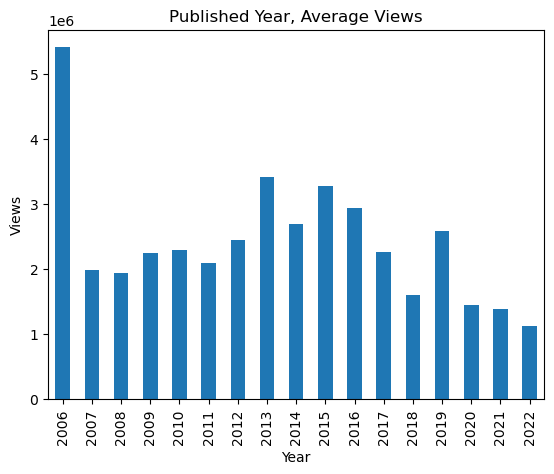

In [127]:
# Yearly average of views by publishing year

yearly_average_pub = df1.groupby(["published_year"])["views"].mean()
yearly_average_pub.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Views')
plt.title('Published Year, Average Views')
plt.xticks(rotation=90)
plt.show()


<Axes: xlabel='recorded_month'>

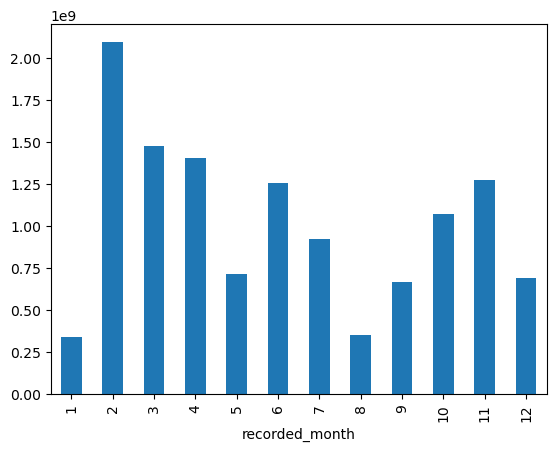

In [114]:
monthly_average_rec = df1.groupby(["recorded_year", "recorded_month"])["views"].sum()

cross_year_average_rec = monthly_average_rec.groupby("recorded_month").sum()

cross_year_average_rec

cross_year_average_rec.plot(kind='bar')

In [194]:
df.groupby("published_year")["views"].sum()

published_year
2006     265293948
2007     241842093
2008     359815610
2009     499541914
2010     582502031
2011     545416070
2012     750886270
2013     832134679
2014     641978957
2015     721912392
2016     703522313
2017     856363822
2018    1149973664
2019    2135894863
2020     956718652
2021     639095884
2022     357855515
Name: views, dtype: int64

In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5701 entries, 0 to 5700
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   talk_id          5701 non-null   int64         
 1   title            5701 non-null   object        
 2   speaker          5700 non-null   object        
 3   recorded_date    5701 non-null   datetime64[ns]
 4   published_date   5701 non-null   datetime64[ns]
 5   event            5700 non-null   object        
 6   duration         5701 non-null   int64         
 7   views            5701 non-null   int64         
 8   likes            5701 non-null   int64         
 9   published_year   5701 non-null   int32         
 10  published_month  5701 non-null   int32         
 11  recorded_year    5701 non-null   int32         
 12  recorded_month   5701 non-null   int32         
 13  percent_likes    5701 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int32(

/Users/drewe/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


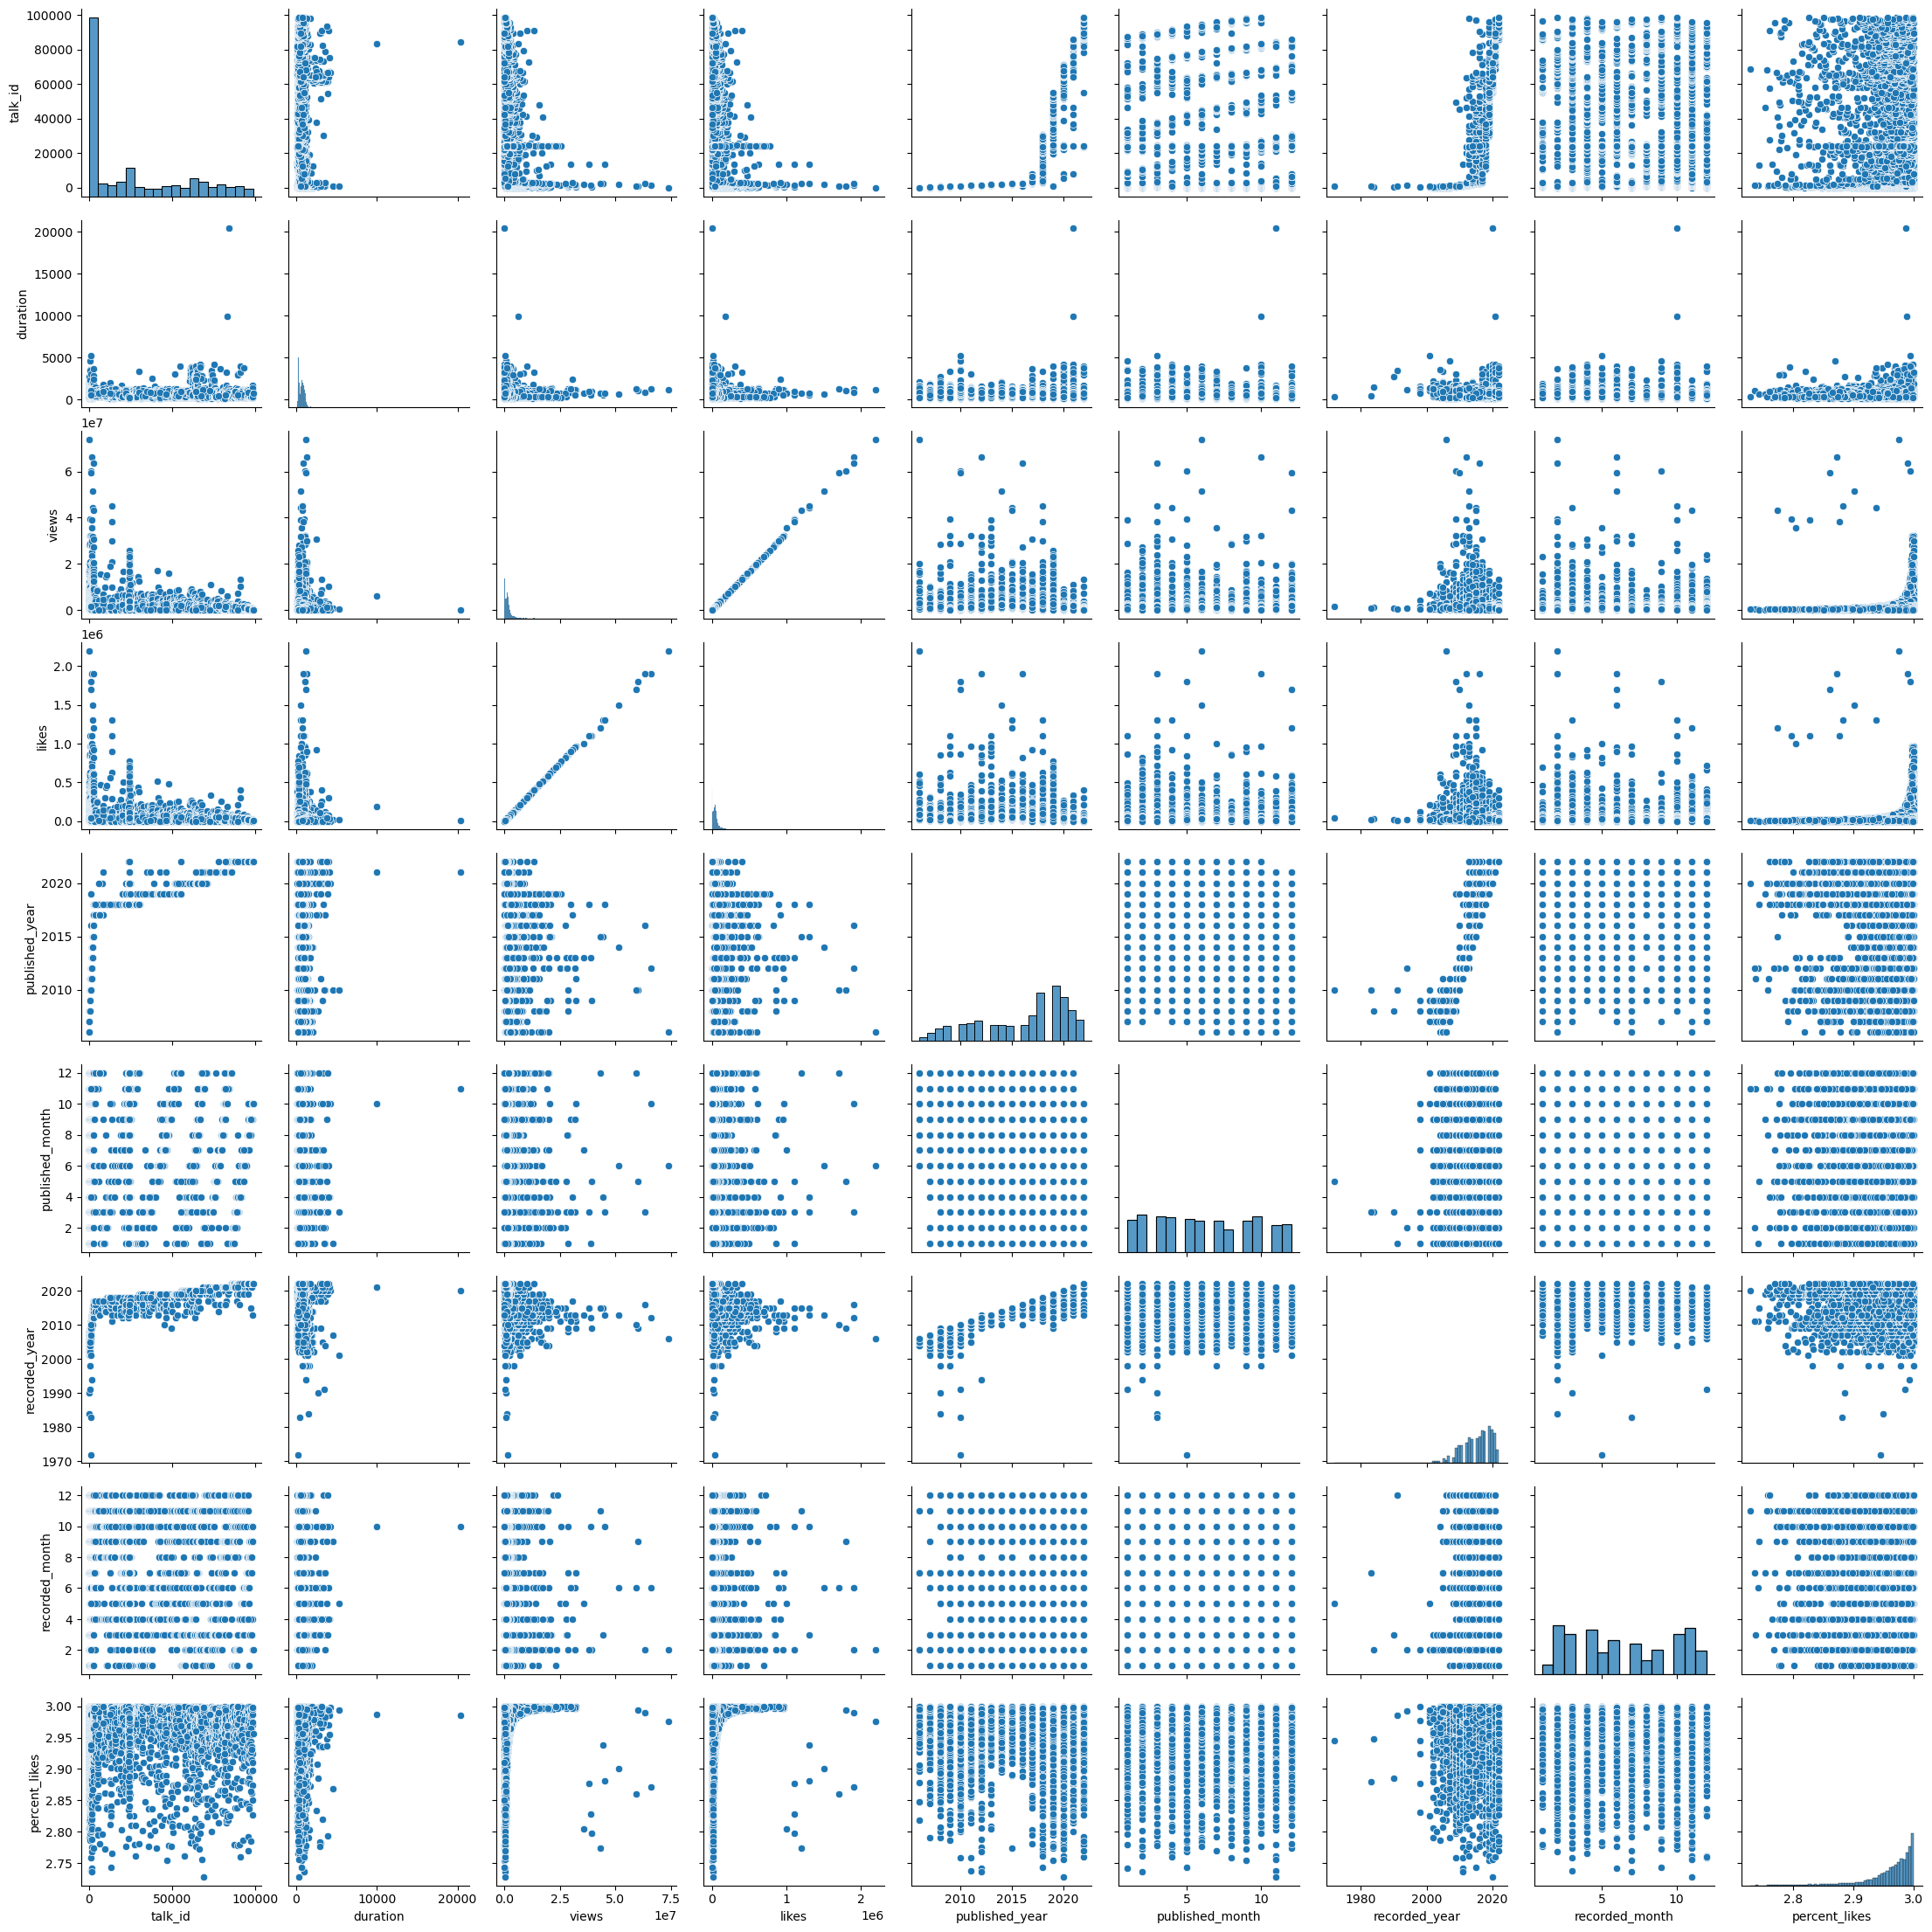

In [77]:
sns.pairplot(data=df1)
plt.show()

<Axes: >

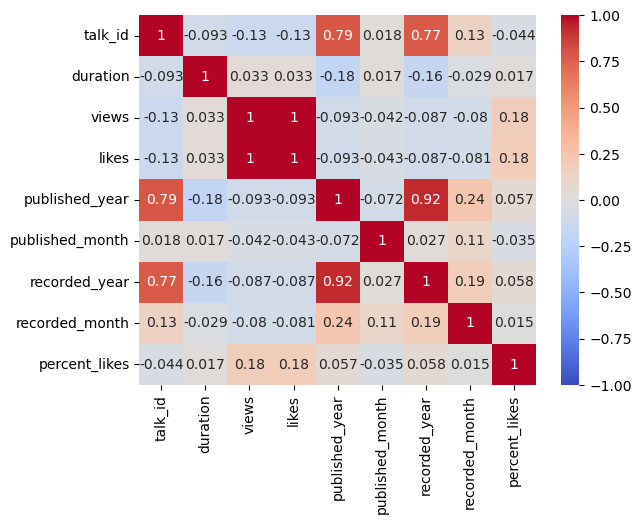

In [85]:
numerical = df1.select_dtypes("number")
sns.heatmap(numerical.corr(),vmin=-1.0,vmax=1.0,cmap='coolwarm',annot=True)

In [198]:
df1.groupby("recorded_year")["views"].mean()

recorded_year
1972    1.392109e+06
1983    6.944140e+05
1984    1.119188e+06
1990    7.280170e+05
1991    3.282550e+05
1994    7.016550e+05
1998    1.324330e+06
2001    2.148505e+06
2002    1.205708e+06
2003    1.650623e+06
2004    3.528891e+06
2005    2.513214e+06
2006    3.797227e+06
2007    1.604593e+06
2008    2.565590e+06
2009    2.481910e+06
2010    2.046966e+06
2011    2.204250e+06
2012    2.765764e+06
2013    2.861112e+06
2014    2.423039e+06
2015    3.273805e+06
2016    2.474413e+06
2017    2.163944e+06
2018    1.820584e+06
2019    1.859145e+06
2020    1.380717e+06
2021    1.402322e+06
2022    1.007166e+06
Name: views, dtype: float64

<Axes: xlabel='views', ylabel='recorded_year'>

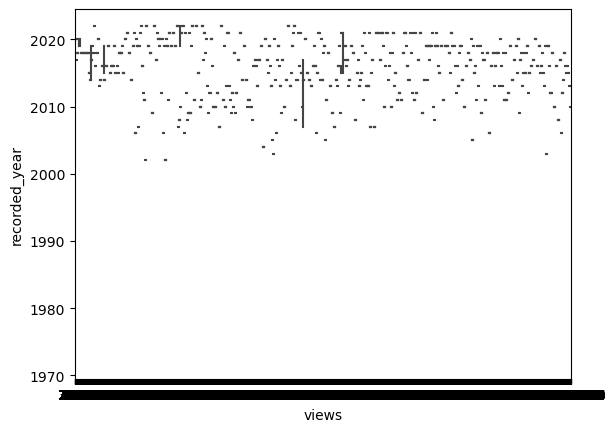

In [202]:
sns.boxplot(x="views", y="recorded_year", data=df1)

In [204]:
# General Correlation Table

df.corr(numeric_only=True)

,talk_id,duration,views,likes,published_year,published_month,recorded_year,recorded_month,percent_likes
talk_id,1.000000,-0.092871,-0.131383,-0.132124,0.787683,0.017785,0.769956,0.133080,-0.043286
duration,-0.092871,1.000000,0.033264,0.033365,-0.181504,0.016504,-0.161523,-0.028893,0.016403
views,-0.131383,0.033264,1.000000,0.999745,-0.092708,-0.042535,-0.087418,-0.080491,0.176993
likes,-0.132124,0.033365,0.999745,1.000000,-0.092811,-0.043352,-0.087611,-0.081260,0.183787
published_year,0.787683,-0.181504,-0.092708,-0.092811,1.000000,-0.071727,0.924854,0.236843,0.057040
published_month,0.017785,0.016504,-0.042535,-0.043352,-0.071727,1.000000,0.027398,0.107913,-0.034605
recorded_year,0.769956,-0.161523,-0.087418,-0.087611,0.924854,0.027398,1.000000,0.186159,0.057813
recorded_month,0.133080,-0.028893,-0.080491,-0.081260,0.236843,0.107913,0.186159,1.000000,0.015224
percent_likes,-0.043286,0.016403,0.176993,0.183787,0.057040,-0.034605,0.057813,0.015224,1.000000


#### Interesting Findings:

percent-likes correlations:
- Views: .176
- Likes: .183

recorded-month:


In [ ]:
# How many talks were there each year?

